# Data Mining
## ver 4.0
@Create 09-04-2022
ver 3.1   
1、修正了自定义的加权平均函数，原权值顺序反了  
2、修正了滚动统计函数，原函数的将mood值的日期+1赋给滚动统计日期的mood值，应为-1  
3、修改了datapreprocess1st函数使用pivot_table代替pivot,可自动聚合，去掉了groupby处理   
ver 3.2   
1、验证了按日合计正确性，与github代码数据一致，不一致为activatiy为score，采用了求平均值，将call、sms统计方式由max修改为sum   
2、自定义函数经验证使用自定义的加权平均函数计算结果正确，可以使用，通过手工计算验证正确   
3、参照github增加了直方图、曲线图绘制  
4、增加了线性插值补齐数据，和绘图   
5、增加了数据列合并删除，github的程序对office和finance合并感觉并不合理，other和unknown合并到other，game和entertainment合并到entertainmen，social和communication合并到social，utilities和weather合并到tools,call和sms合并到call，根据文献circumplex.arousal、circumplex.valence和相关性，circumplex.valence对mood的影响较大，而circumplex.arousal较弱，所以删除circumplex.arousal较弱
6、完成了决策树回归 
ver 3.3   
1、增加了数据平稳性检验   
2、增加了数据自相关性检验   
3、增加了AMIMA模型   
4、增加了VAR模型   
ver 4.0   
1、增加了benchmark模型,采用决策树，以合并未1天的插值后数据集，保留全部属性作为特征   
2、修改了特征模型,采用多元线性回归、决策树回归和随机森林   
3、增加了特征处理函数，可合并多个属性，或删除属性
3、重新梳理了时间序列模型ARIMA模型   
4、暂时删除VAR模型   
### 目前基本完成了全部内容,从统计学模型评价上看，特征模型和时间模型均不如使用1天的全属性特征评价，主要原因是由于原始数据较为离散，各属性相关性较差，合并为1天后属性显示出各自的相关性，也符合心理健康领域的规律，而通过滚动合并为多日的时间段数据后，本以为可以增加时间属性，但反而增大了噪声，减弱了原属性间的相关性，造成预测结果反而不如benchmark模型，而时间模型使用statsmodels和pmdarima库的ARIMA，由于时间关系未作深入了解，从时间关系上只能每个用户建立模型，而每个id的数据量很少，造成了预测结果不理想，而且通过观察发现其季节性基本为7天，而模型只能设置为季度、月等，无法设置如此小的间隔，也是预测结果不理想的原因之一

In [13]:
"""
@author Group 17-Yunshan Wang(1721621@student.vu.nl 2721621)
@Create 09-04-2022
Data Proprocess
"""
#-*- coding:utf-8 -*-
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

%matplotlib inline

def readcsvfile(csvfilename):
    '''
    读取csv文件，返回dataframe
    
    Args:
        csvfilename: 含路径的csv文件名
        
    Returns:
        读取的dataframe
    '''
    if os.path.exists(csvfilename):
        return pd.read_csv(csvfilename)
    else:
        print('Error:The file {} does not exist!'.format(csvfilename))

path = "E:\\pythonprj\\datamining\\"
filename = 'dataset_mood_smartphone.csv'
df=readcsvfile(path+filename) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376912 entries, 0 to 376911
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  376912 non-null  int64  
 1   id          376912 non-null  object 
 2   time        376912 non-null  object 
 3   variable    376912 non-null  object 
 4   value       376710 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 14.4+ MB


## Data Prepress and Exploratory Data Analysis
### 1. 初步数据预处理
数据集：376912行x5列 数据集处理后：358922行x21列   
具体处理见函数为datapreprocess1st   
1) 列处理：通过查看数据描述和统计,第一列Unnamed为序号时无意义列，删除该列，time列为object类型，转换为时间类型  
2）NaN数据处理：数据共376912行，id,time,variable均NaN，而value有37670行非空，删除202行NaN值行  
3）不合理数据处理：activity(number between 0 and 1),appCat.builtin、appCat.entertainment等使用时间数据不能未负值，删除负值  
4）不合理数据处理：相同'id','time','variable'数据，'value'不同，通过求平均值合并   
5）数据转换：将'variable'，'value'转换为列  
6) (可不处理）异常值处理：通过观察df.describe(),发现最大值与Q3(75%值）差异较大，从hist图中可以看到数据分布异常，见表1和图1，对其进行处理，替换为Q3+1.5xIQR后，见表2和图2 


In [14]:
def datapreprocess1st(df):
    '''
    数据预处理转换时间戳，删除无效列、NaN值、不合理行(如持续时间小于0)、重复行等

    Args:
        df: dataframe
    Returns:
        处理后的dataframe
    '''
    # 第0列为序号无意义，删除第0列unnamed
    df.drop(df.columns[0],axis=1,inplace=True)
    
    # df.info()查看value列有空值，删除NaN,删除了202行
    df.dropna(axis=0, how='any', inplace=True)
    
    # 将time列转换时间序列，object->datetime64[ns]
    df['time']=pd.to_datetime(df['time'])
    
    # 正数列:activity取值[0，1],其它的为使用时间，均应为正数，其中删除小于0的行，删除了4行
    positivecols=['activity' ,'screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
    df = df.query('variable in @positivecols & value>=0 | variable not in @positivecols')
    
   
    # 'id','time',将'variable'，'value'转换为列,pivot_table对'id','time','variable'相同的求平均
    df = df.pivot_table(index=['id','time'],columns='variable',values='value')
    
    return df  

df=datapreprocess1st(df)
df.to_csv('dataset_1st.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358922 entries, ('AS14.01', Timestamp('2014-02-17 12:04:42.394000')) to ('AS14.33', Timestamp('2014-05-31 12:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity              22965 non-null  float64
 1   appCat.builtin        91285 non-null  float64
 2   appCat.communication  74276 non-null  float64
 3   appCat.entertainment  27124 non-null  float64
 4   appCat.finance        939 non-null    float64
 5   appCat.game           813 non-null    float64
 6   appCat.office         5642 non-null   float64
 7   appCat.other          7650 non-null   float64
 8   appCat.social         19145 non-null  float64
 9   appCat.travel         2846 non-null   float64
 10  appCat.unknown        939 non-null    float64
 11  appCat.utilities      2487 non-null   float64
 12  appCat.weather        255 non-null    float64
 13  call                  5239 no

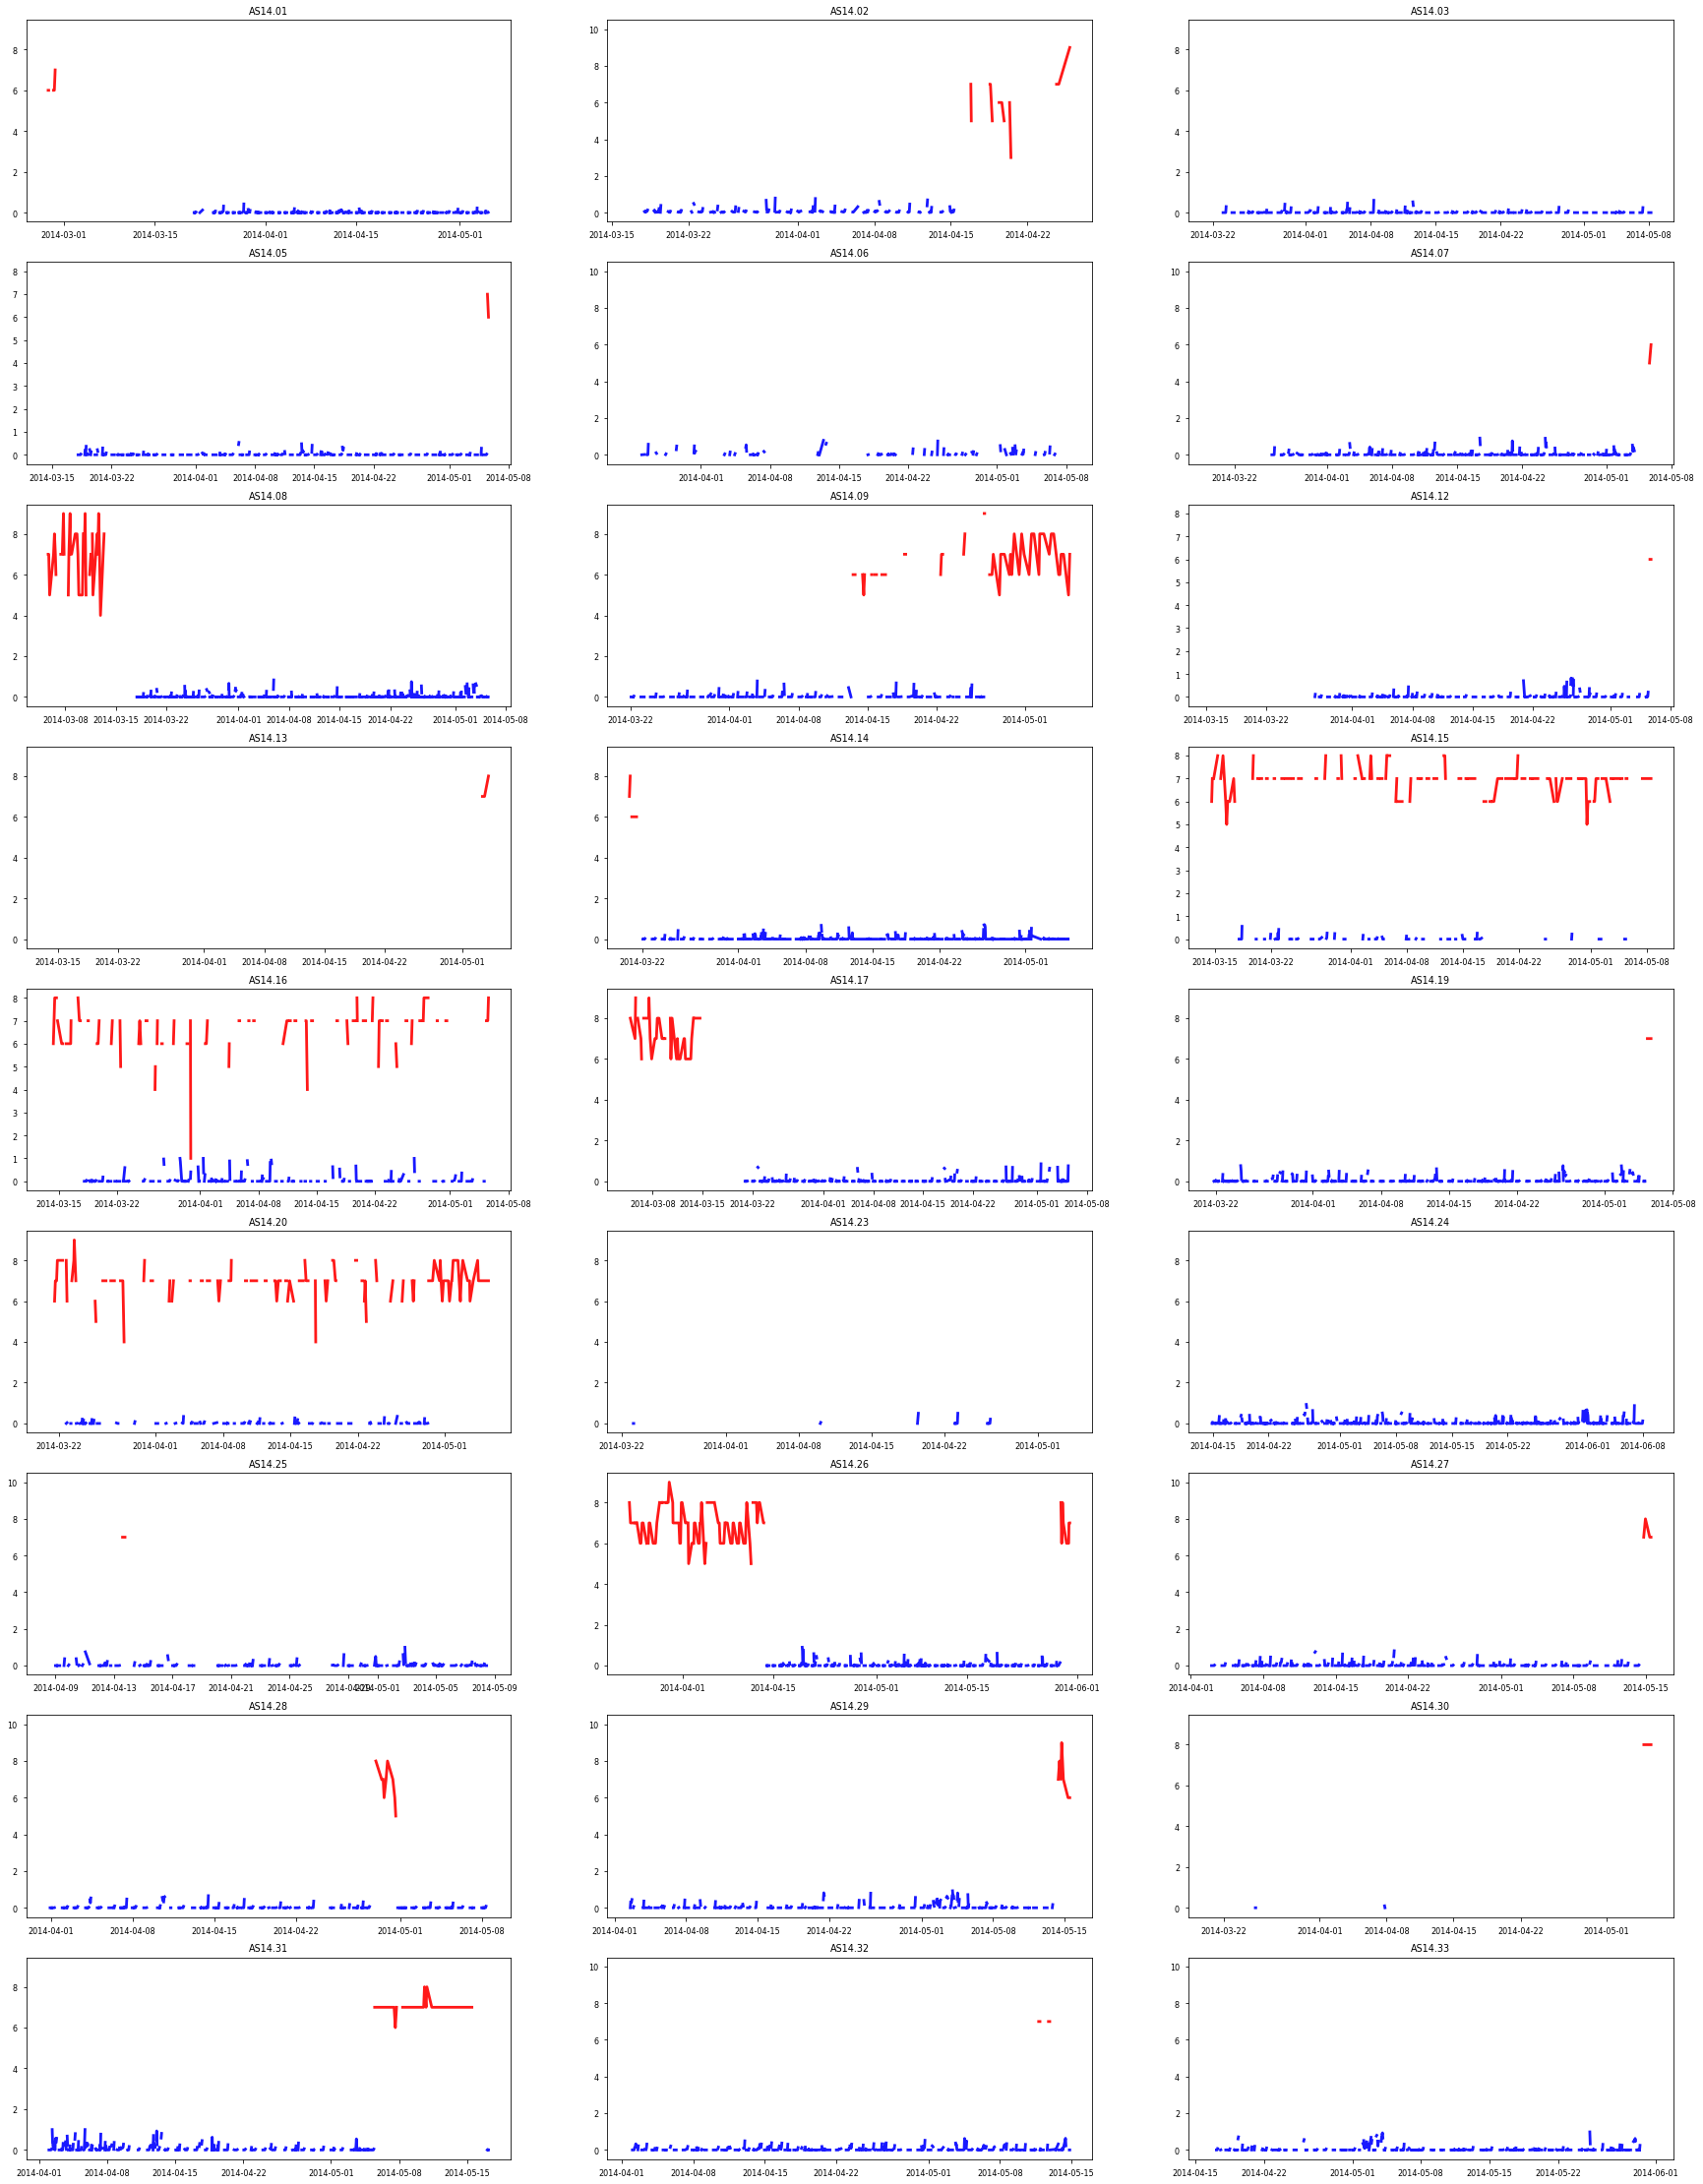

In [15]:
# 绘图观察转换后数据的连续情况
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(30,40))
cols=['mood','activity']
for i,val in enumerate(list(df.index.levels[0])):
    ax = fig.add_subplot(9,3, i+1)
    ax.set_title(val)
    ax.plot(df.loc[val,cols[0]], marker='', color='r', linewidth=2.8, alpha=0.9, label=val)
    ax.plot(df.loc[val,cols[1]], marker='', color='b', linewidth=2.8, alpha=0.9, label=val)

### 表1 删除异常值前数据

In [11]:
df.describe()

variable,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
count,22965.000000,91285.000000,74276.000000,27124.000000,939.000000,813.000000,5642.000000,7650.000000,19145.000000,2846.000000,939.000000,2487.000000,255.000000,5239.0,5582.000000,5474.000000,5628.000000,96578.000000,1798.0
mean,0.115958,19.446411,43.343792,37.577866,21.755251,128.391615,22.578892,25.810839,72.401906,45.730850,45.553006,18.537552,20.148714,1.0,-0.098173,0.688893,6.993870,75.335206,1.0
std,0.186946,312.914956,128.912750,262.965225,39.218361,327.145246,449.601382,112.781355,261.551846,246.109307,119.400405,60.959134,24.943431,0.0,1.051164,0.670048,1.031496,253.822497,0.0
min,0.000000,0.001000,0.006000,0.001000,0.131000,1.003000,0.003000,0.014000,0.094000,0.080000,0.111000,0.246000,1.003000,1.0,-2.000000,-2.000000,1.000000,0.035000,1.0
25%,0.000000,2.020000,5.218000,1.334000,4.072000,14.148000,2.004000,7.019000,9.030000,5.086500,5.018000,3.158500,8.684000,1.0,-1.000000,0.000000,7.000000,5.322250,1.0
50%,0.021739,4.038000,16.225500,3.391500,8.026000,43.168000,3.106000,10.028000,28.466000,18.144000,17.190000,8.030000,15.117000,1.0,0.000000,1.000000,7.000000,20.044500,1.0
75%,0.158333,9.922000,45.475750,14.922250,20.155000,123.625000,8.043750,16.829250,75.372000,47.227250,44.430500,19.331000,25.349000,1.0,1.000000,1.000000,8.000000,62.540250,1.0
max,1.000000,33960.246000,9830.777000,32148.677000,355.513000,5491.793000,32708.818000,3892.038000,30000.906000,10452.615000,2239.937000,1802.649000,344.863000,1.0,2.000000,2.000000,10.000000,9867.007000,1.0


### 数据的相关性

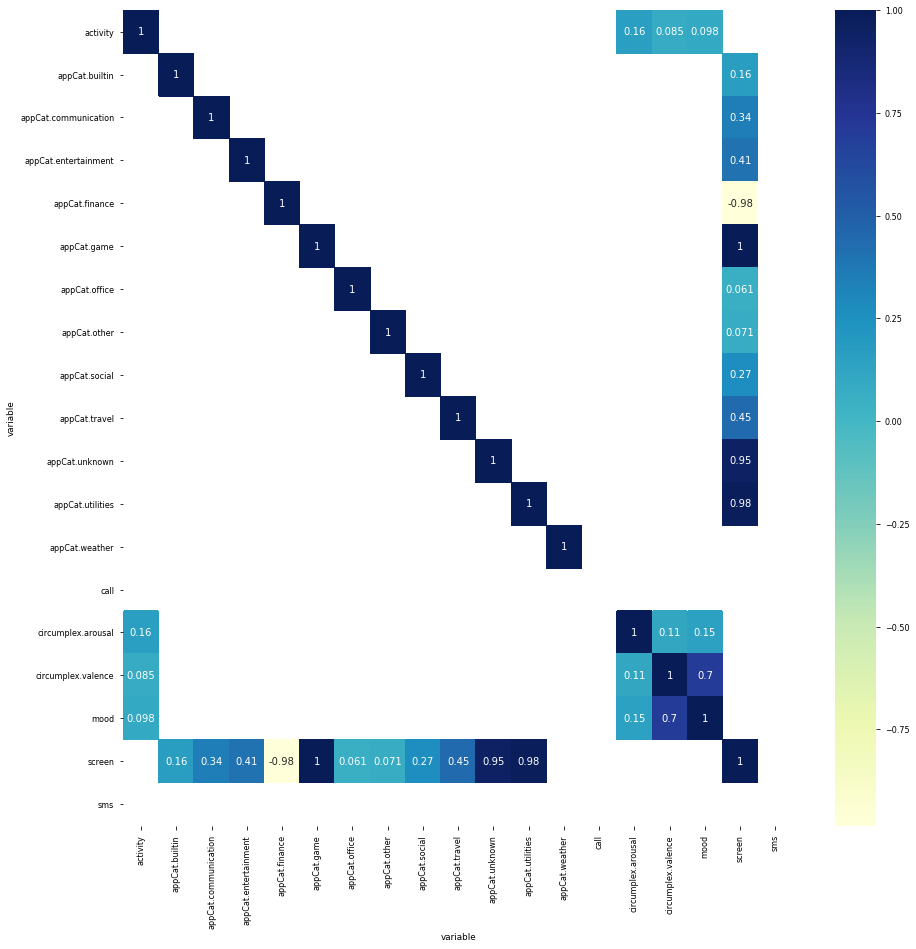

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu");

### 图1 删除异常值前数据Hish图

array([[<AxesSubplot:title={'center':'screen'}>,
        <AxesSubplot:title={'center':'appCat.builtin'}>,
        <AxesSubplot:title={'center':'appCat.communication'}>,
        <AxesSubplot:title={'center':'appCat.entertainment'}>],
       [<AxesSubplot:title={'center':'appCat.finance'}>,
        <AxesSubplot:title={'center':'appCat.game'}>,
        <AxesSubplot:title={'center':'appCat.office'}>,
        <AxesSubplot:title={'center':'appCat.other'}>],
       [<AxesSubplot:title={'center':'appCat.social'}>,
        <AxesSubplot:title={'center':'appCat.travel'}>,
        <AxesSubplot:title={'center':'appCat.unknown'}>,
        <AxesSubplot:title={'center':'appCat.utilities'}>],
       [<AxesSubplot:title={'center':'appCat.weather'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

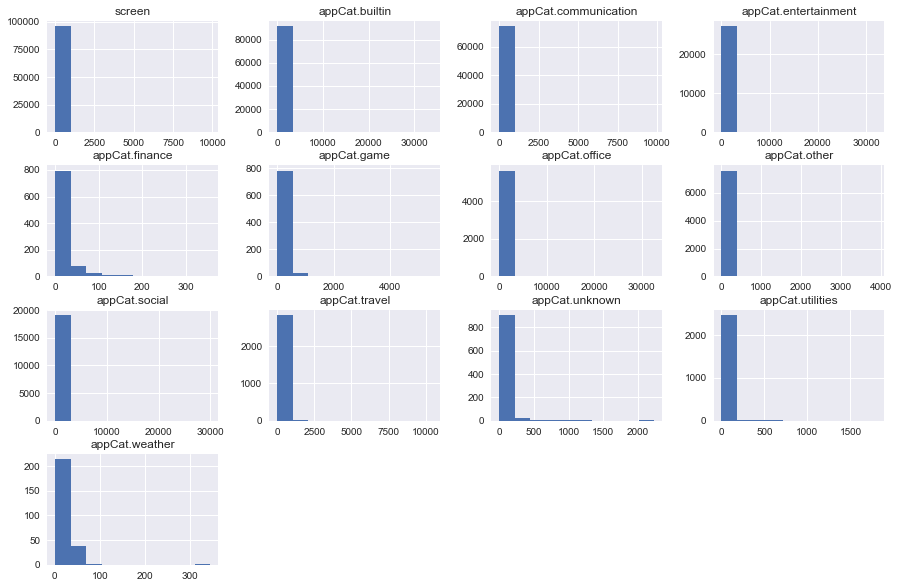

In [312]:
timecols=['screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
df.hist(timecols,figsize=(15,10))

### 1.1替换异常值（可不执行）
注意：未验证替换异常值后对结果的影响，因时间关系未评估采用何种替换效果好，因此是否采用及何种方式替换，需有时间评估对模型效果后决定是否执行该步骤

In [16]:
def removeoutliers(df,cols,mode=0):
    '''
    异常值处理
    Args:
        df      ：需处理的dataframe
        cols    ：需处理的列        
        mode    ：process mode，1：NaN，2：mean，3: 75th percentiles，4: 50th percentiles 
    Returns:
        处理后的dataframe
    '''
    dfdesb=df.describe()[cols]
    if mode==1:
        values=pd.Series(np.nan,index=cols)
    elif mode==2:
        values=dfdesb.loc['mean']
    elif mode==3:
        values=dfdesb.loc['75%']
    elif mode==4:
        values=dfdesb.loc['50%']
    else :     
        for col in cols:
            #  reeplace with Q3+1.5xIQR when data > Q3+1.5xIQR 
            df.loc[df[col] > dfdesb[col]['75%']+1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col] = dfdesb[col]['75%'] + 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%'])
            #  reeplace with Q1-1.5xIQR when data < Q1-1.5xIQR 
            #tmp.loc[tmp[col] < dfdesb[col]['25%']-1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col] = dfdesb[col]['25%'] - 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%'])
        return df
    
    for col in cols:
        #  reeplace with values when data > Q3+1.5xIQR or data <Q1-1.5xIQR
        df.loc[df[col] > dfdesb[col]['75%'] + 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col]= values[col]
        #tmp.loc[tmp[col] < dfdesb[col]['25%'] - 1.5*(dfdesb[col]['75%']-dfdesb[col]['25%']),col]= values[col]
    return df
    
# remove outliers，选择执行
timecols=['screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
df = removeoutliers(df,timecols)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358922 entries, ('AS14.01', Timestamp('2014-02-17 12:04:42.394000')) to ('AS14.33', Timestamp('2014-05-31 12:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity              22965 non-null  float64
 1   appCat.builtin        91285 non-null  float64
 2   appCat.communication  74276 non-null  float64
 3   appCat.entertainment  27124 non-null  float64
 4   appCat.finance        939 non-null    float64
 5   appCat.game           813 non-null    float64
 6   appCat.office         5642 non-null   float64
 7   appCat.other          7650 non-null   float64
 8   appCat.social         19145 non-null  float64
 9   appCat.travel         2846 non-null   float64
 10  appCat.unknown        939 non-null    float64
 11  appCat.utilities      2487 non-null   float64
 12  appCat.weather        255 non-null    float64
 13  call                  5239 no

### 表2 替换异常值后数据描述

In [17]:
df.describe()

variable,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
count,22965.000000,91285.000000,74276.000000,27124.000000,939.000000,813.000000,5642.000000,7650.000000,19145.000000,2846.000000,939.000000,2487.000000,255.000000,5239.0,5582.000000,5474.000000,5628.000000,96578.000000,1798.0
mean,0.115958,7.050873,30.757341,10.317920,14.474768,83.588817,5.948709,12.981498,51.517141,31.395787,29.504299,12.944640,18.664055,1.0,-0.098173,0.688893,6.993870,42.247384,1.0
std,0.186946,6.759849,32.991631,12.788385,14.252193,93.197834,5.631424,9.327186,55.670662,32.675497,31.908903,12.625708,13.462081,0.0,1.051164,0.670048,1.031496,48.203883,0.0
min,0.000000,0.001000,0.006000,0.001000,0.131000,1.003000,0.003000,0.014000,0.094000,0.080000,0.111000,0.246000,1.003000,1.0,-2.000000,-2.000000,1.000000,0.035000,1.0
25%,0.000000,2.020000,5.218000,1.334000,4.072000,14.148000,2.004000,7.019000,9.030000,5.086500,5.018000,3.158500,8.684000,1.0,-1.000000,0.000000,7.000000,5.322250,1.0
50%,0.021739,4.038000,16.225500,3.391500,8.026000,43.168000,3.106000,10.028000,28.466000,18.144000,17.190000,8.030000,15.117000,1.0,0.000000,1.000000,7.000000,20.044500,1.0
75%,0.158333,9.922000,45.475750,14.922250,20.155000,123.625000,8.043750,16.829250,75.372000,47.227250,44.430500,19.331000,25.349000,1.0,1.000000,1.000000,8.000000,62.540250,1.0
max,1.000000,21.775000,105.862375,35.304625,44.279500,287.840500,17.103375,31.544625,174.885000,110.438375,103.549250,43.589750,50.346500,1.0,2.000000,2.000000,10.000000,148.367250,1.0


### 图2 替换异常值后数据hish图

array([[<AxesSubplot:title={'center':'screen'}>,
        <AxesSubplot:title={'center':'appCat.builtin'}>,
        <AxesSubplot:title={'center':'appCat.communication'}>,
        <AxesSubplot:title={'center':'appCat.entertainment'}>],
       [<AxesSubplot:title={'center':'appCat.finance'}>,
        <AxesSubplot:title={'center':'appCat.game'}>,
        <AxesSubplot:title={'center':'appCat.office'}>,
        <AxesSubplot:title={'center':'appCat.other'}>],
       [<AxesSubplot:title={'center':'appCat.social'}>,
        <AxesSubplot:title={'center':'appCat.travel'}>,
        <AxesSubplot:title={'center':'appCat.unknown'}>,
        <AxesSubplot:title={'center':'appCat.utilities'}>],
       [<AxesSubplot:title={'center':'appCat.weather'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

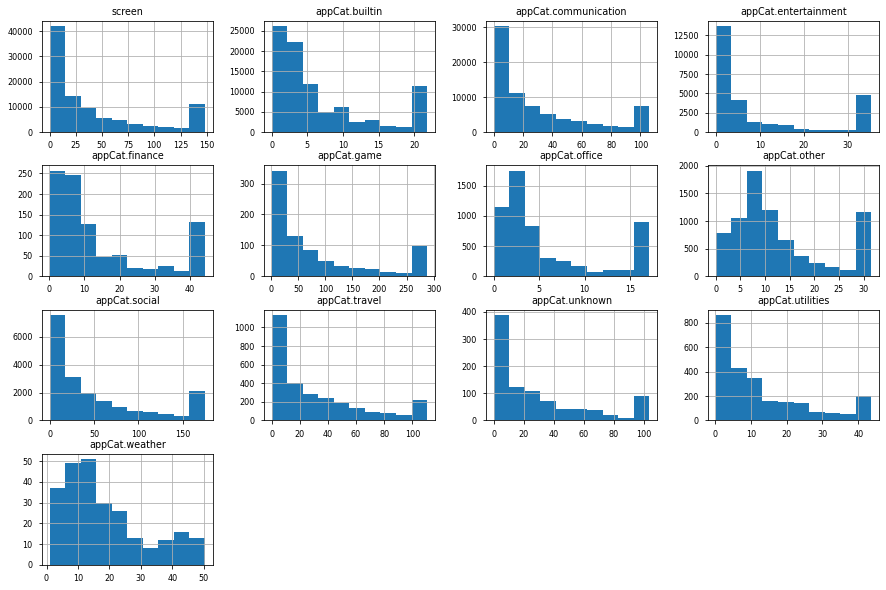

In [18]:
timecols=['screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
df.hist(timecols,figsize=(15,10))

### 2. 时间序列数据按日合并
数据集中用户每天的的数据包括了多个时间的值,需要按天合并数据,针对不同属性使用不同的统计方法,mood,circumplex.arousal,circumplex.valence,activity为不同时段的评分,因此将多个时段评分去Mean,计算出该日的评分,call,sms为是否进行了该操作,因此只要该天任意时段为1，该日就为1，因此取Max，而其余的screen,appCat.builtin等为每个时间段的时长，对其进行求Sum计算出总的时长.
合并前数据集：358922x21，合并后数据集1973x21
具体实现见函数datatransformforday

In [19]:
def datatransformforday(df):
    '''
    数据集转换，将variable转换为属性，并按日合并

    Args:
        df             ：需转换的dataframe
        
    Returns:
        转换后的dataframe
    
    '''
    
    df.reset_index(inplace=True)

    # 对每个'id' 按天合并计算，合并方法保存在polymerizationcols字典中
    polymerizationcols={'mood':'mean','circumplex.arousal':'mean','circumplex.valence':'mean','activity':'mean','call':'sum','screen':'sum',
                        'sms':'sum','appCat.builtin':'sum','appCat.communication':'sum','appCat.entertainment':'sum','appCat.finance':'sum',
                        'appCat.game':'sum','appCat.office':'sum','appCat.other':'sum','appCat.social':'sum','appCat.travel':'sum',
                        'appCat.unknown':'sum','appCat.utilities':'sum','appCat.weather':'sum'}
    df=df.groupby(['id',pd.Grouper(key='time',freq='D')]).agg(polymerizationcols).reset_index()
    df.set_index(['id','time'],inplace=True,drop=True)
    return df

df1d=datatransformforday(df)
df1d.to_csv('dataset_mood_1d.csv')
df1d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1973 entries, ('AS14.01', Timestamp('2014-02-17 00:00:00')) to ('AS14.33', Timestamp('2014-05-31 00:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1268 non-null   float64
 1   circumplex.arousal    1268 non-null   float64
 2   circumplex.valence    1266 non-null   float64
 3   activity              1188 non-null   float64
 4   call                  1973 non-null   float64
 5   screen                1973 non-null   float64
 6   sms                   1973 non-null   float64
 7   appCat.builtin        1973 non-null   float64
 8   appCat.communication  1973 non-null   float64
 9   appCat.entertainment  1973 non-null   float64
 10  appCat.finance        1973 non-null   float64
 11  appCat.game           1973 non-null   float64
 12  appCat.office         1973 non-null   float64
 13  appCat.other          1973 non-null   

In [20]:
df1d.describe()

,mood,circumplex.arousal,circumplex.valence,activity,call,screen,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather
count,1268.000000,1268.000000,1266.000000,1188.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000,1973.000000
mean,6.990254,-0.103910,0.687632,0.120003,2.655347,2068.001928,0.911303,326.223489,1157.897737,141.846563,6.888904,34.443846,17.010956,50.333734,499.896430,45.287587,14.041833,16.316938,2.412232
std,0.736317,0.662954,0.434361,0.098301,3.452197,2432.689544,1.848397,460.387269,1565.893848,289.462744,32.117763,183.411590,89.696364,79.460246,949.153761,140.336475,67.064167,77.233451,14.200515
min,3.000000,-2.000000,-1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.600000,-0.600000,0.400000,0.054872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,0.800000,0.095634,1.000000,1127.492501,0.000000,102.409000,426.212375,0.000000,0.000000,0.000000,0.000000,31.308000,1.007000,0.000000,0.000000,0.000000,0.000000
75%,7.500000,0.400000,1.000000,0.149358,4.000000,3646.019253,1.000000,518.751000,1879.273125,158.700875,0.000000,0.000000,0.000000,70.062000,612.538000,0.000000,0.000000,0.000000,0.000000
max,9.333333,2.000000,2.000000,0.566171,31.000000,12942.379511,17.000000,2771.124000,11213.609125,2730.650750,687.084000,3435.841500,1071.512500,1111.777375,14145.498000,1647.172750,1734.239250,1687.552000,303.357000


### 绘图查看数据连续情况

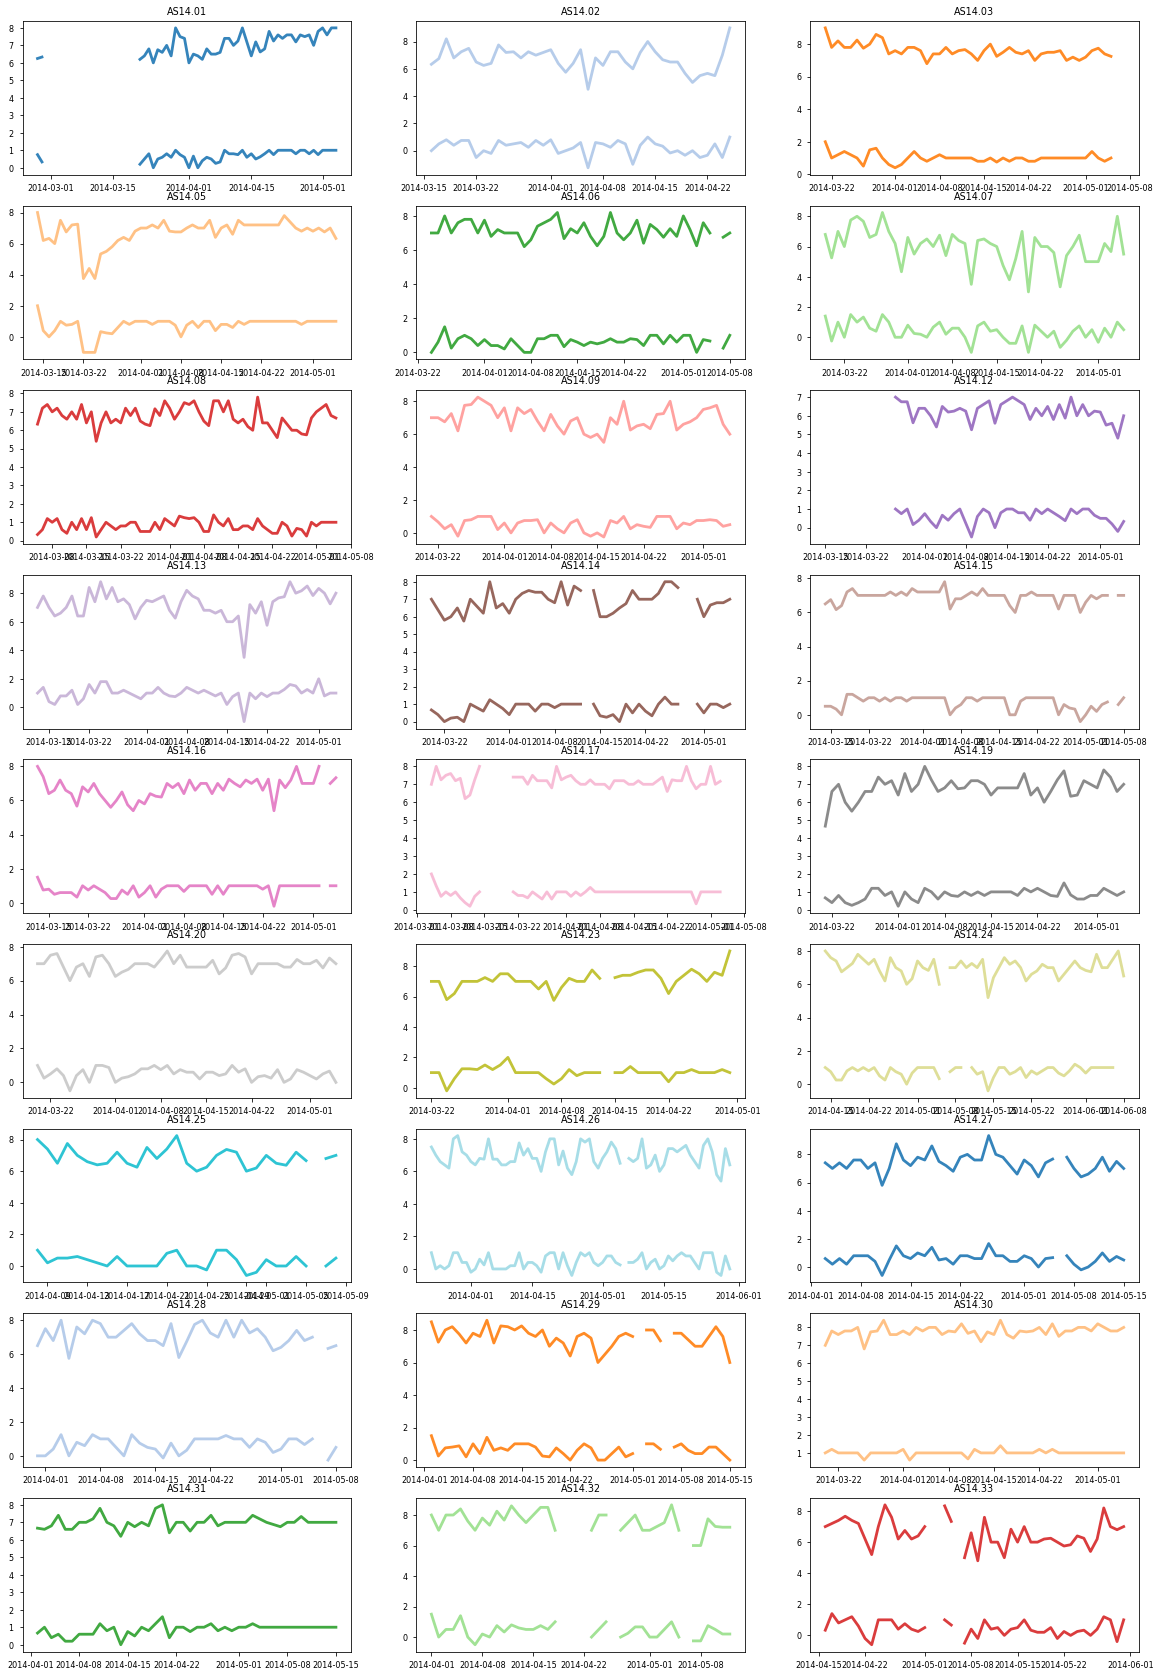

In [21]:
# 绘图查看插值结果
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(20,30))
cols=['mood','circumplex.valence']
for i,val in enumerate(list(df1d.index.levels[0])):
    ax = fig.add_subplot(9,3, i+1)
    ax.set_title(val)
    ax.plot(df1d.loc[val,cols], marker='', color=palette(i%20), linewidth=2.8, alpha=0.9, label=val)

### 2.1 删除孤立数据   
可以看到AS14.01和AS14.12有孤立的数据，对于时间序列中间值缺少数据较多，如果插值会影响分析结果

In [22]:
# 删除孤立的数据
df1d.drop(index = ('AS14.01','2014-02-26'),axis = 1,inplace=True)
df1d.drop(index = ('AS14.01','2014-02-27'),axis = 1,inplace=True)
df1d.drop(index = ('AS14.12','2014-03-15'),axis = 1,inplace=True)
df1d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1970 entries, ('AS14.01', Timestamp('2014-02-17 00:00:00')) to ('AS14.33', Timestamp('2014-05-31 00:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1265 non-null   float64
 1   circumplex.arousal    1265 non-null   float64
 2   circumplex.valence    1263 non-null   float64
 3   activity              1188 non-null   float64
 4   call                  1970 non-null   float64
 5   screen                1970 non-null   float64
 6   sms                   1970 non-null   float64
 7   appCat.builtin        1970 non-null   float64
 8   appCat.communication  1970 non-null   float64
 9   appCat.entertainment  1970 non-null   float64
 10  appCat.finance        1970 non-null   float64
 11  appCat.game           1970 non-null   float64
 12  appCat.office         1970 non-null   float64
 13  appCat.other          1970 non-null   

### 3 对每个ID的时间序列中间缺失数据进行插值补充

In [23]:
# 将除评分外的列中的0值替换为NaN，为插值做准备
dealcols=['call','sms','screen','appCat.builtin','appCat.communication','appCat.entertainment','appCat.finance','appCat.game',
             'appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
# 替换所有0值未NaN，为插值做准备
df1d.loc[:,dealcols]=df1d.loc[:,dealcols].replace(to_replace=0,value=np.nan)
# 删除索引，取出id
df1d.reset_index(inplace=True)
ids = df1d.id.unique()
frames = [] 
# 分别对每个id操作
for i in ids:
    data_id = df1d[df1d.id == i]
    # 取出mood值不为NaN的时间最小值，最大值
    starttime=data_id[data_id['mood'].notnull()]['time'].min()
    endtime=data_id[data_id['mood'].notnull()]['time'].max()
    # 删除前面的值和后面的值（因为没有初始值和结束值），只补充插值中间丢失的值
    data_id = data_id.drop(data_id[(data_id['time']<starttime) | (data_id['time']>endtime)].index)
    data_id.set_index(['id','time'],inplace=True)
    #对空值替换，线性插值，也可采用别的插值方式
    data_id_inter = data_id.interpolate(axis=0)
    frames.append(data_id_inter)
    # 将不同id的数据集合并
newdf1d=pd.concat(frames,ignore_index=False)
#newdf1d.set_index(['id','time'],inplace=True)
df1d.set_index(['id','time'],inplace=True)
df1d.sort_index(inplace=True)
newdf1d.sort_index(inplace=True)
newdf1d.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1295 entries, ('AS14.01', Timestamp('2014-03-21 00:00:00')) to ('AS14.33', Timestamp('2014-05-31 00:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1295 non-null   float64
 1   circumplex.arousal    1295 non-null   float64
 2   circumplex.valence    1295 non-null   float64
 3   activity              1216 non-null   float64
 4   call                  1262 non-null   float64
 5   screen                1249 non-null   float64
 6   sms                   1246 non-null   float64
 7   appCat.builtin        1249 non-null   float64
 8   appCat.communication  1249 non-null   float64
 9   appCat.entertainment  1210 non-null   float64
 10  appCat.finance        559 non-null    float64
 11  appCat.game           464 non-null    float64
 12  appCat.office         848 non-null    float64
 13  appCat.other          1246 non-null   

### 插值结果绘图

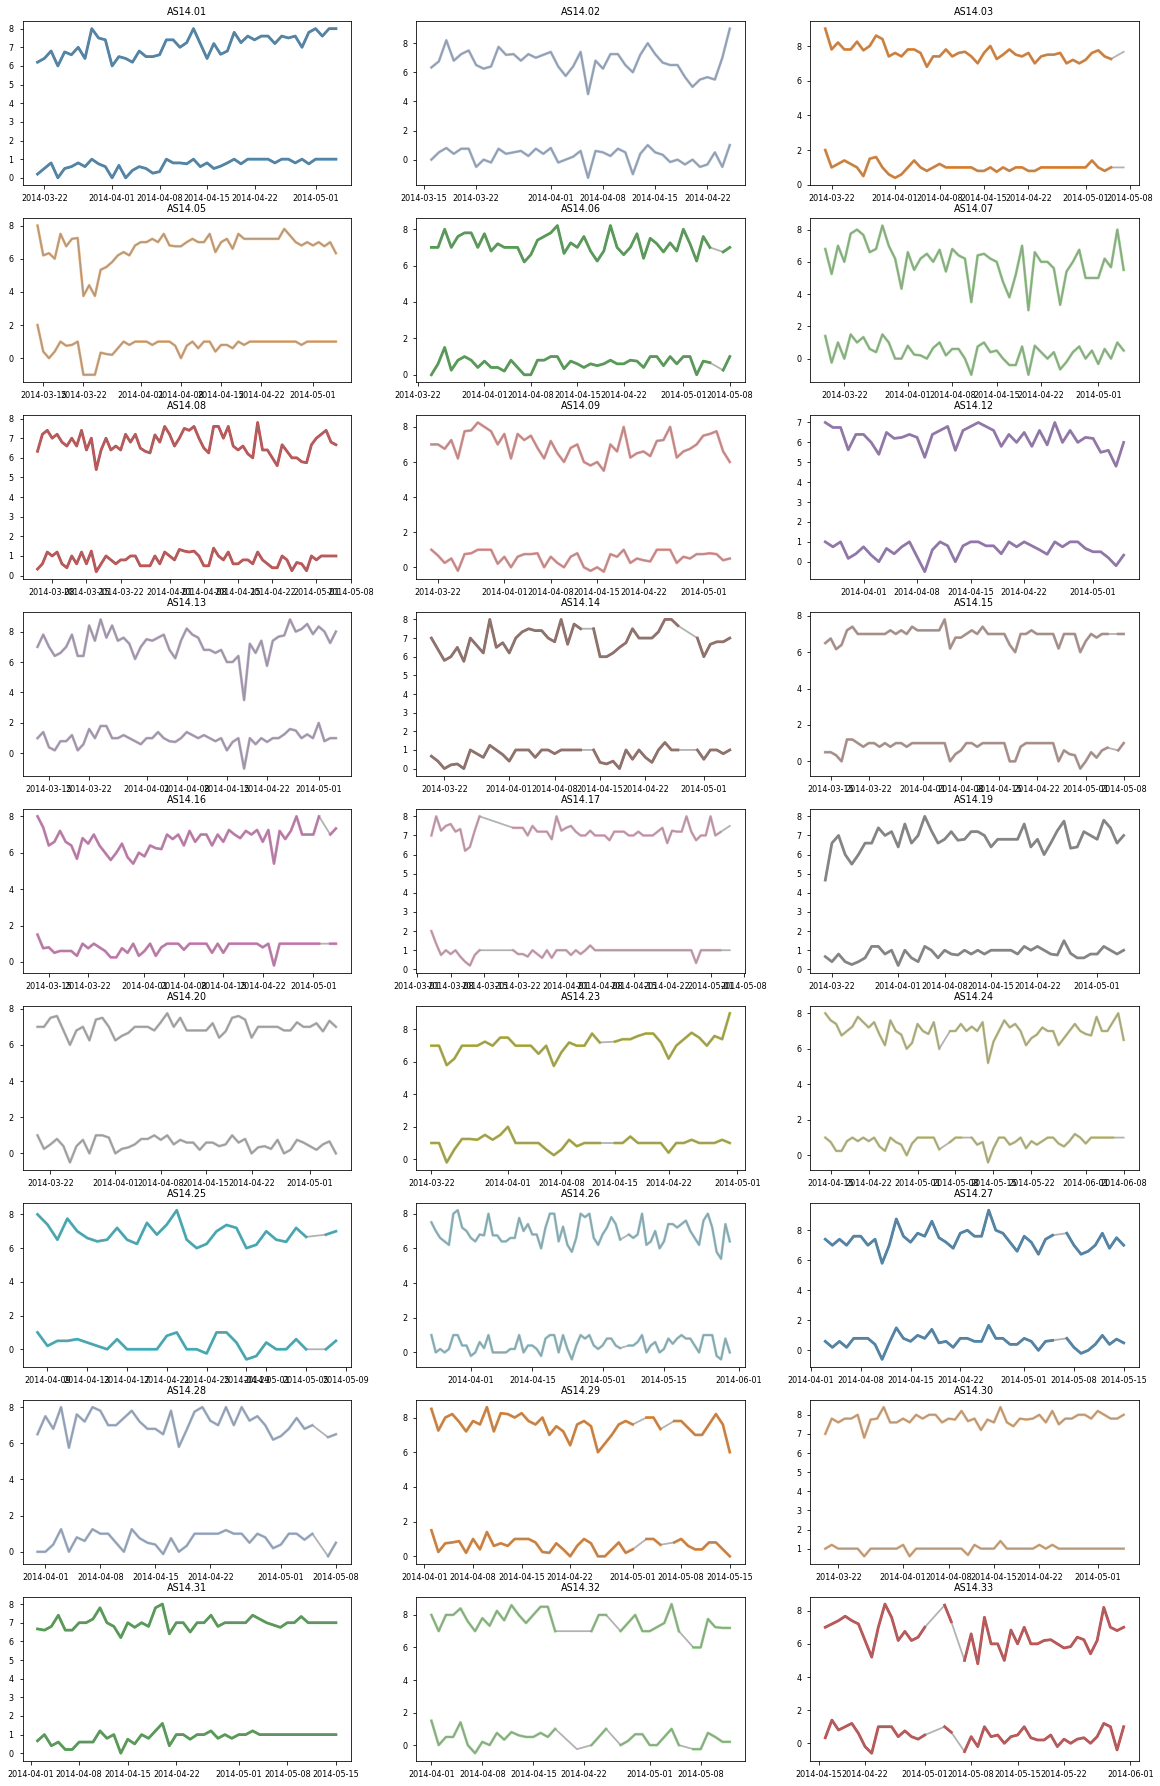

In [24]:
# 绘图查看插值结果
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')
fig = plt.figure(figsize=(20,32))
cols=['mood','circumplex.valence']
for i,val in enumerate(list(df1d.index.levels[0])):
    ax = fig.add_subplot(9,3, i+1)
    ax.set_title(val)
    ax.plot(df1d.loc[val,cols], marker='', color=palette(i%20), linewidth=2.8, alpha=0.9, label=val)
    ax.plot(newdf1d.loc[val,cols], marker='', color='grey', linewidth=1.8, alpha=0.6)


### 数据分布

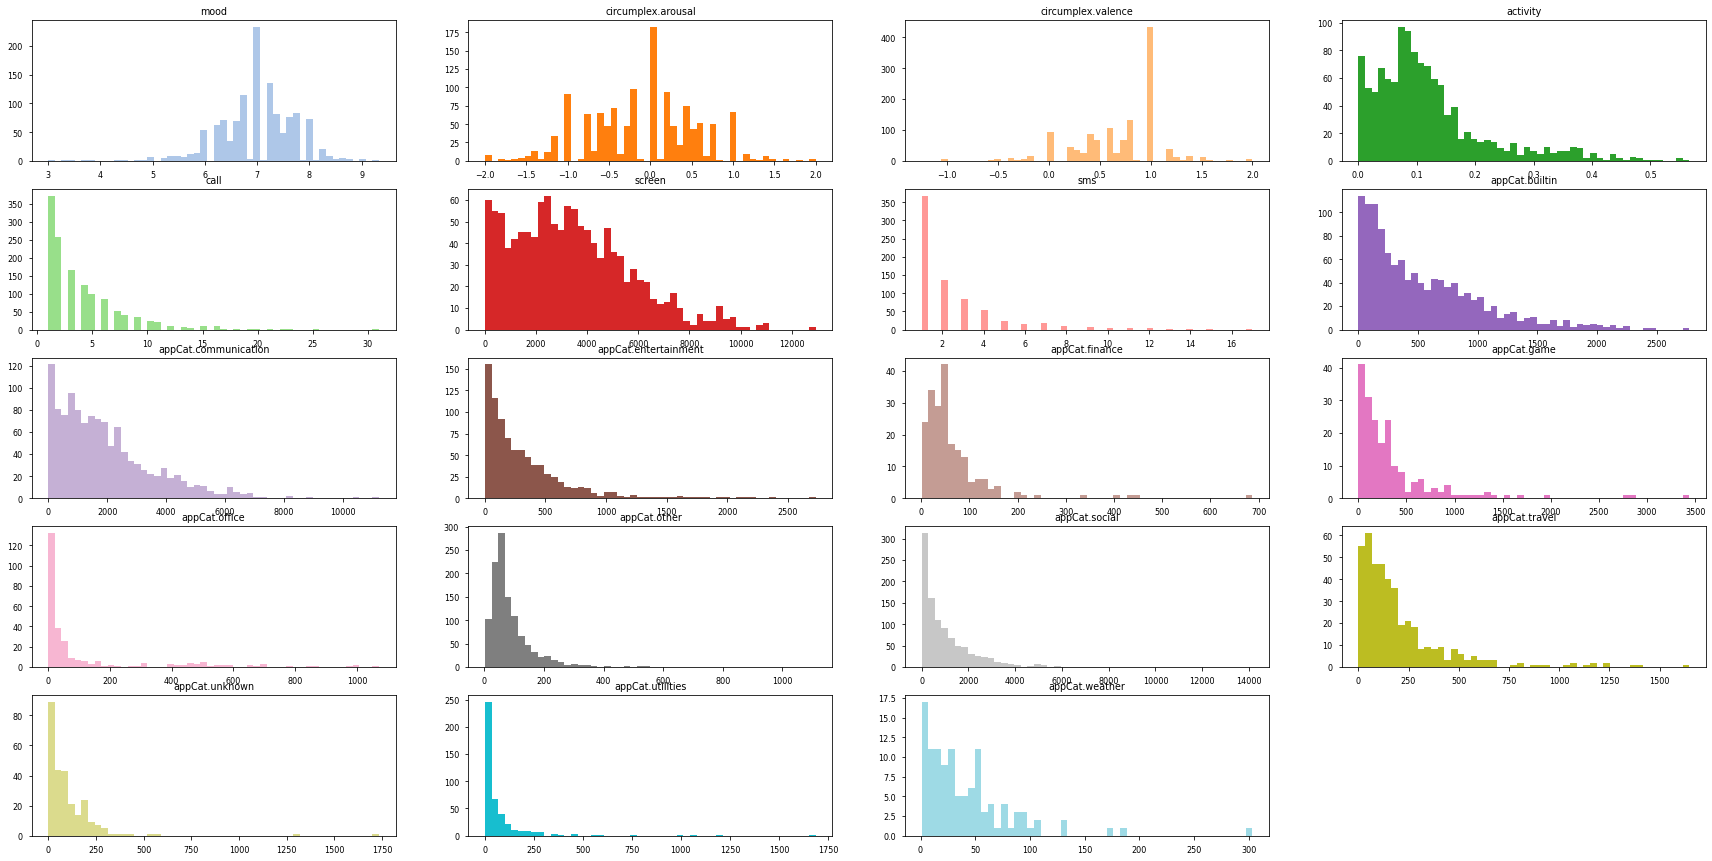

In [25]:
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,15))
for i,val in enumerate(list(df1d.columns.array)):
    ax = fig.add_subplot(5,4,i+1)
    data = np.asarray(df1d[val].dropna())
    ax.hist(data, bins=50, color=palette((i+1)))
    ax.set_title(val)


### 相关性分析
可以看到跟文献中的circumplex模型一致，circumplex.valence对mood的影响较大，而circumplex.arousal较弱,activity与mood有一定的相关性

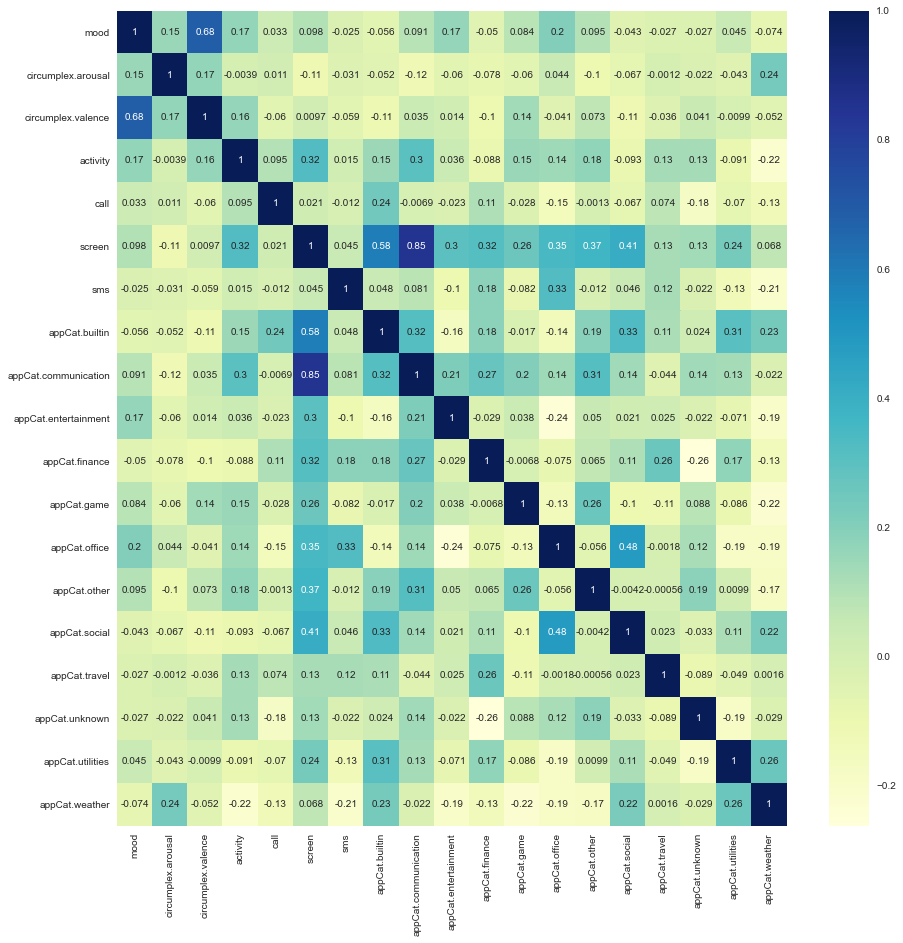

In [26]:
newdf1d.corr()
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df1d.corr(), annot=True, cmap="YlGnBu");

In [27]:
# 使用ADF Test
from statsmodels.tsa.stattools import adfuller

plotdf=newdf1d.copy()
plotdf.fillna(0,inplace=True)

ids = plotdf.index.levels[0].unique()
def stationary(id,column):
    series = plotdf.loc[id, column].values
    result = adfuller(series, autolag='AIC')
    return {'Column':column,'Stationary':result[1]<0.05,'ADF Statistic':result[0],'p-value':result[1]}
for id in ids:
    result=stationary(id,'mood')
    print('{} Mood Stationary:{}'.format(id,result['Stationary']))


AS14.01 Mood Stationary:True
AS14.02 Mood Stationary:True
AS14.03 Mood Stationary:True
AS14.05 Mood Stationary:False
AS14.06 Mood Stationary:True
AS14.07 Mood Stationary:True
AS14.08 Mood Stationary:True
AS14.09 Mood Stationary:True
AS14.12 Mood Stationary:True
AS14.13 Mood Stationary:False
AS14.14 Mood Stationary:True
AS14.15 Mood Stationary:True
AS14.16 Mood Stationary:True
AS14.17 Mood Stationary:True
AS14.19 Mood Stationary:True
AS14.20 Mood Stationary:True
AS14.23 Mood Stationary:False
AS14.24 Mood Stationary:True
AS14.25 Mood Stationary:True
AS14.26 Mood Stationary:True
AS14.27 Mood Stationary:True
AS14.28 Mood Stationary:True
AS14.29 Mood Stationary:True
AS14.30 Mood Stationary:True
AS14.31 Mood Stationary:True
AS14.32 Mood Stationary:True
AS14.33 Mood Stationary:True


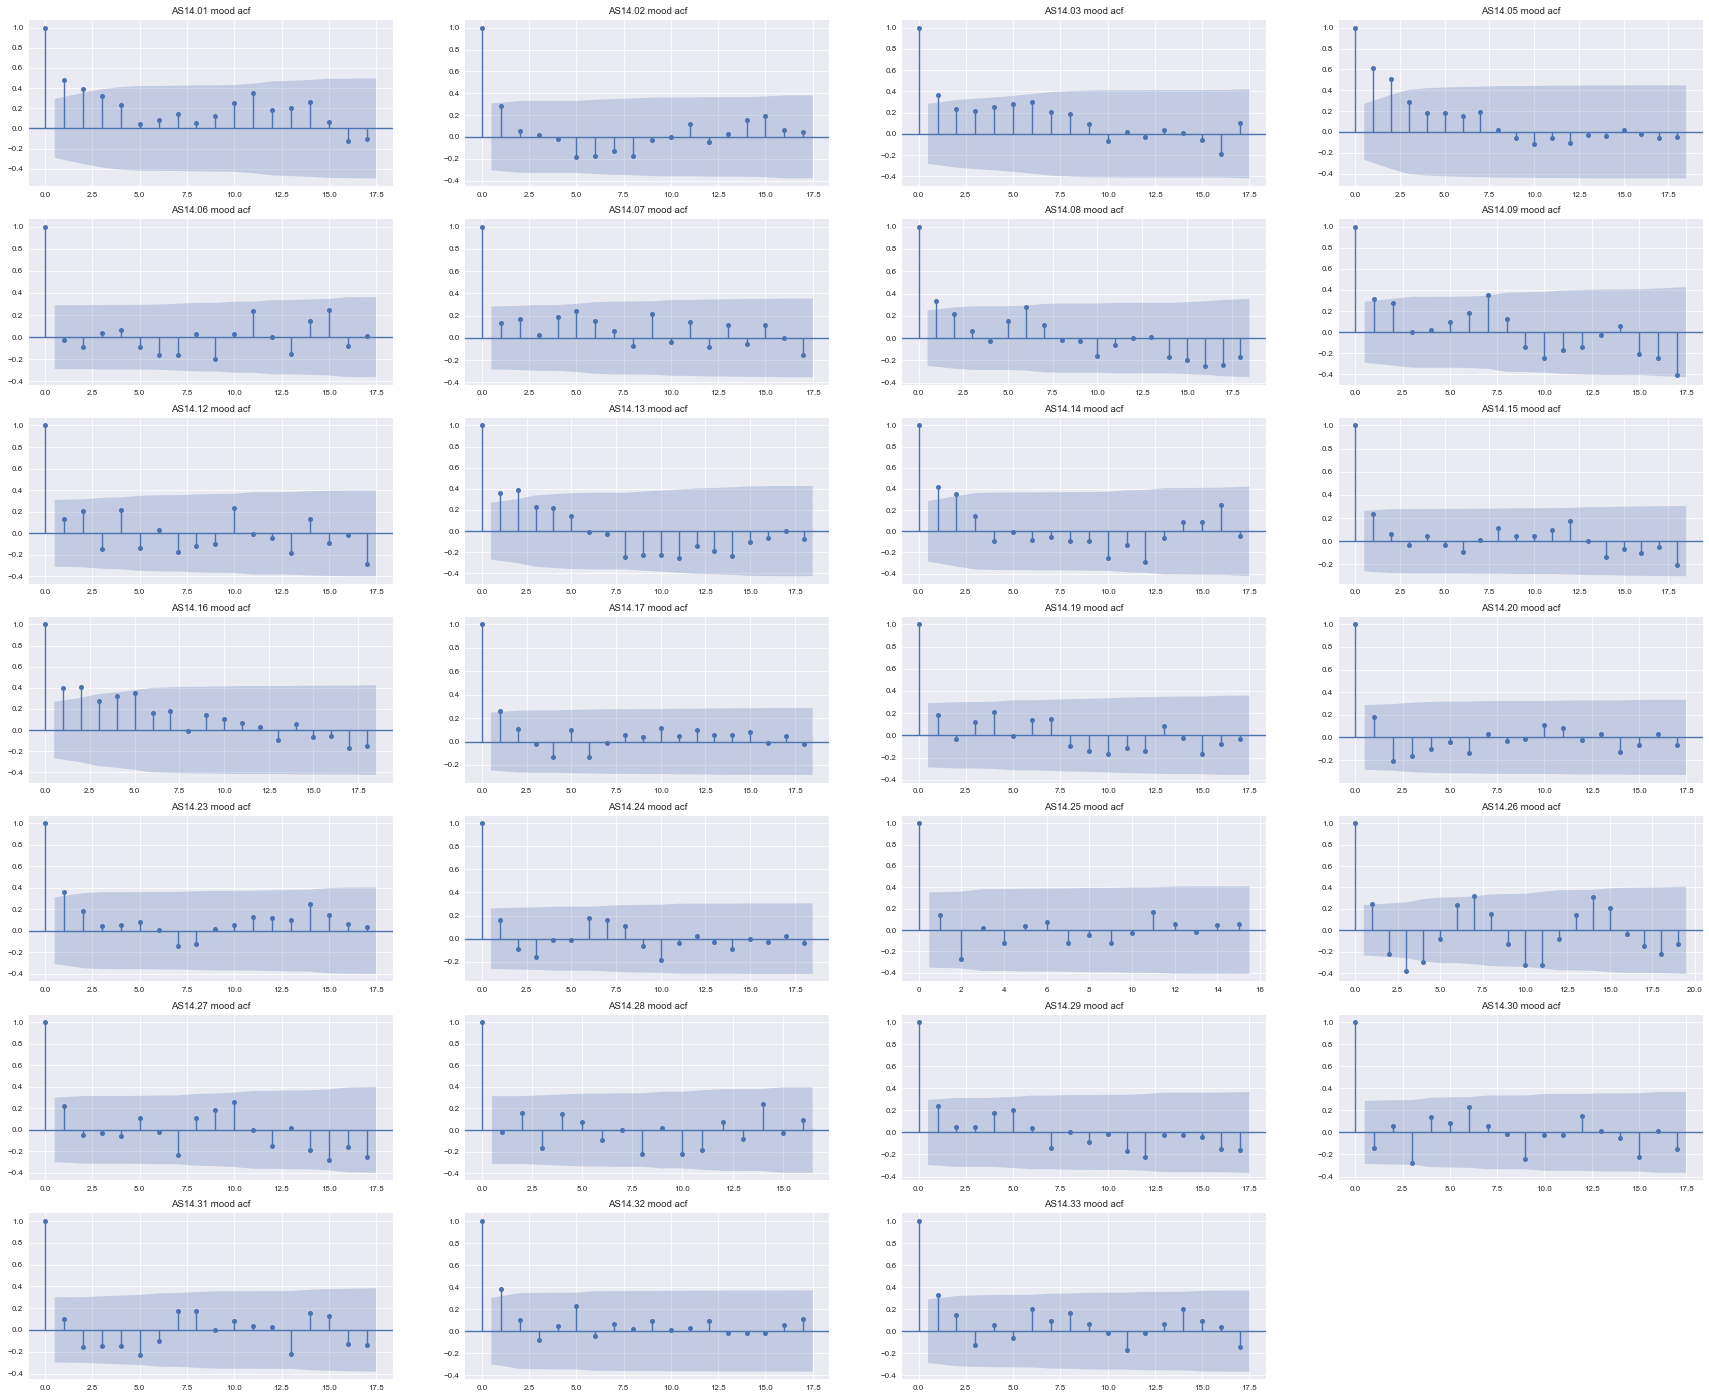

In [28]:
# 画出acf函数
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,25))
for i,id in enumerate(ids):
    ax = fig.add_subplot(7,4,i+1)
    series = plotdf.loc[id, 'mood'].values
    plot_acf(series,ax=ax)
    ax.set_title(id+' mood acf')

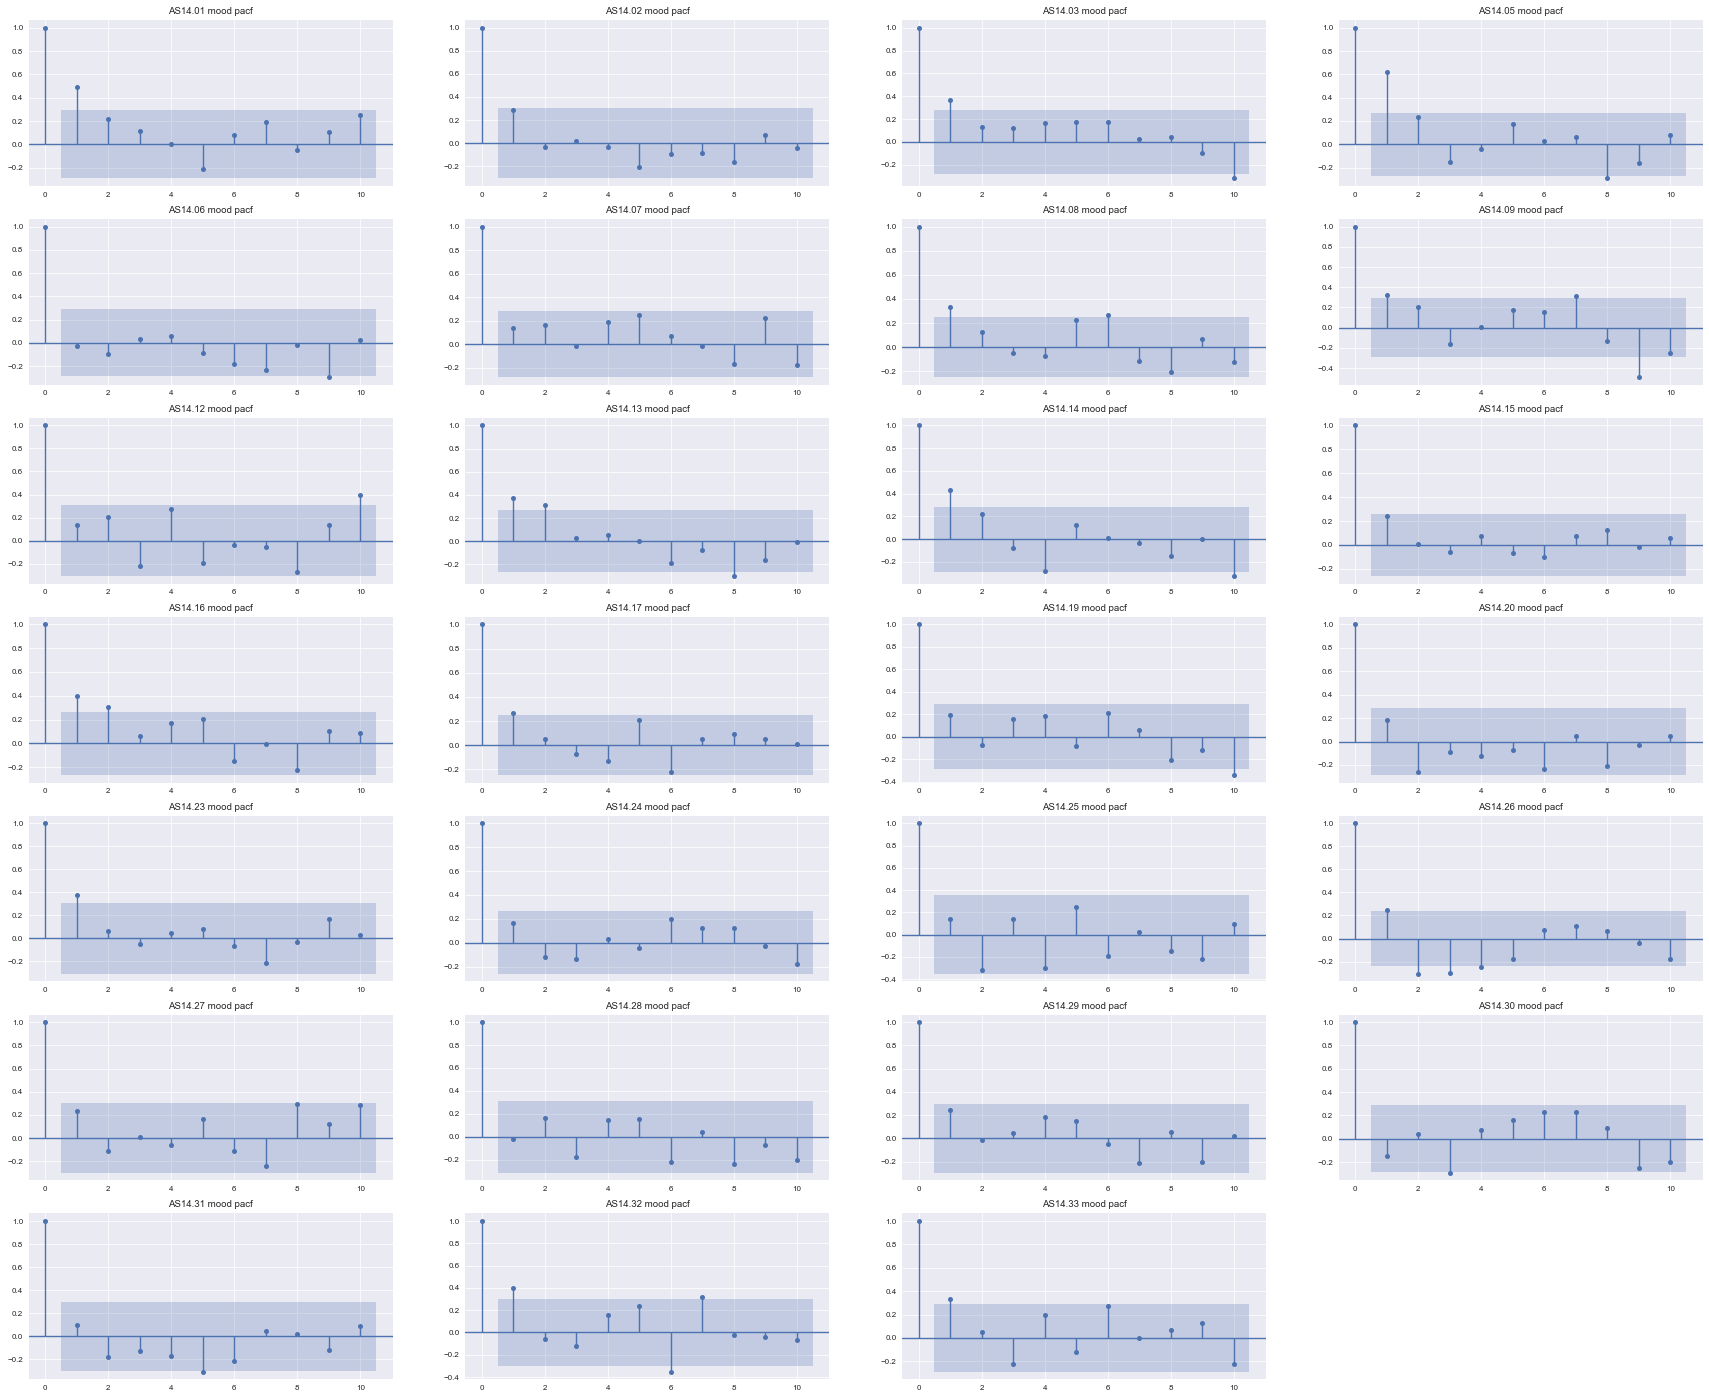

In [29]:
# 画出pacf函数
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,25))
for i,id in enumerate(ids):
    ax = fig.add_subplot(7,4,i+1)
    series = plotdf.loc[id, 'mood'].values
    plot_pacf(series,ax=ax,lags=10)
    ax.set_title(id+' mood pacf')


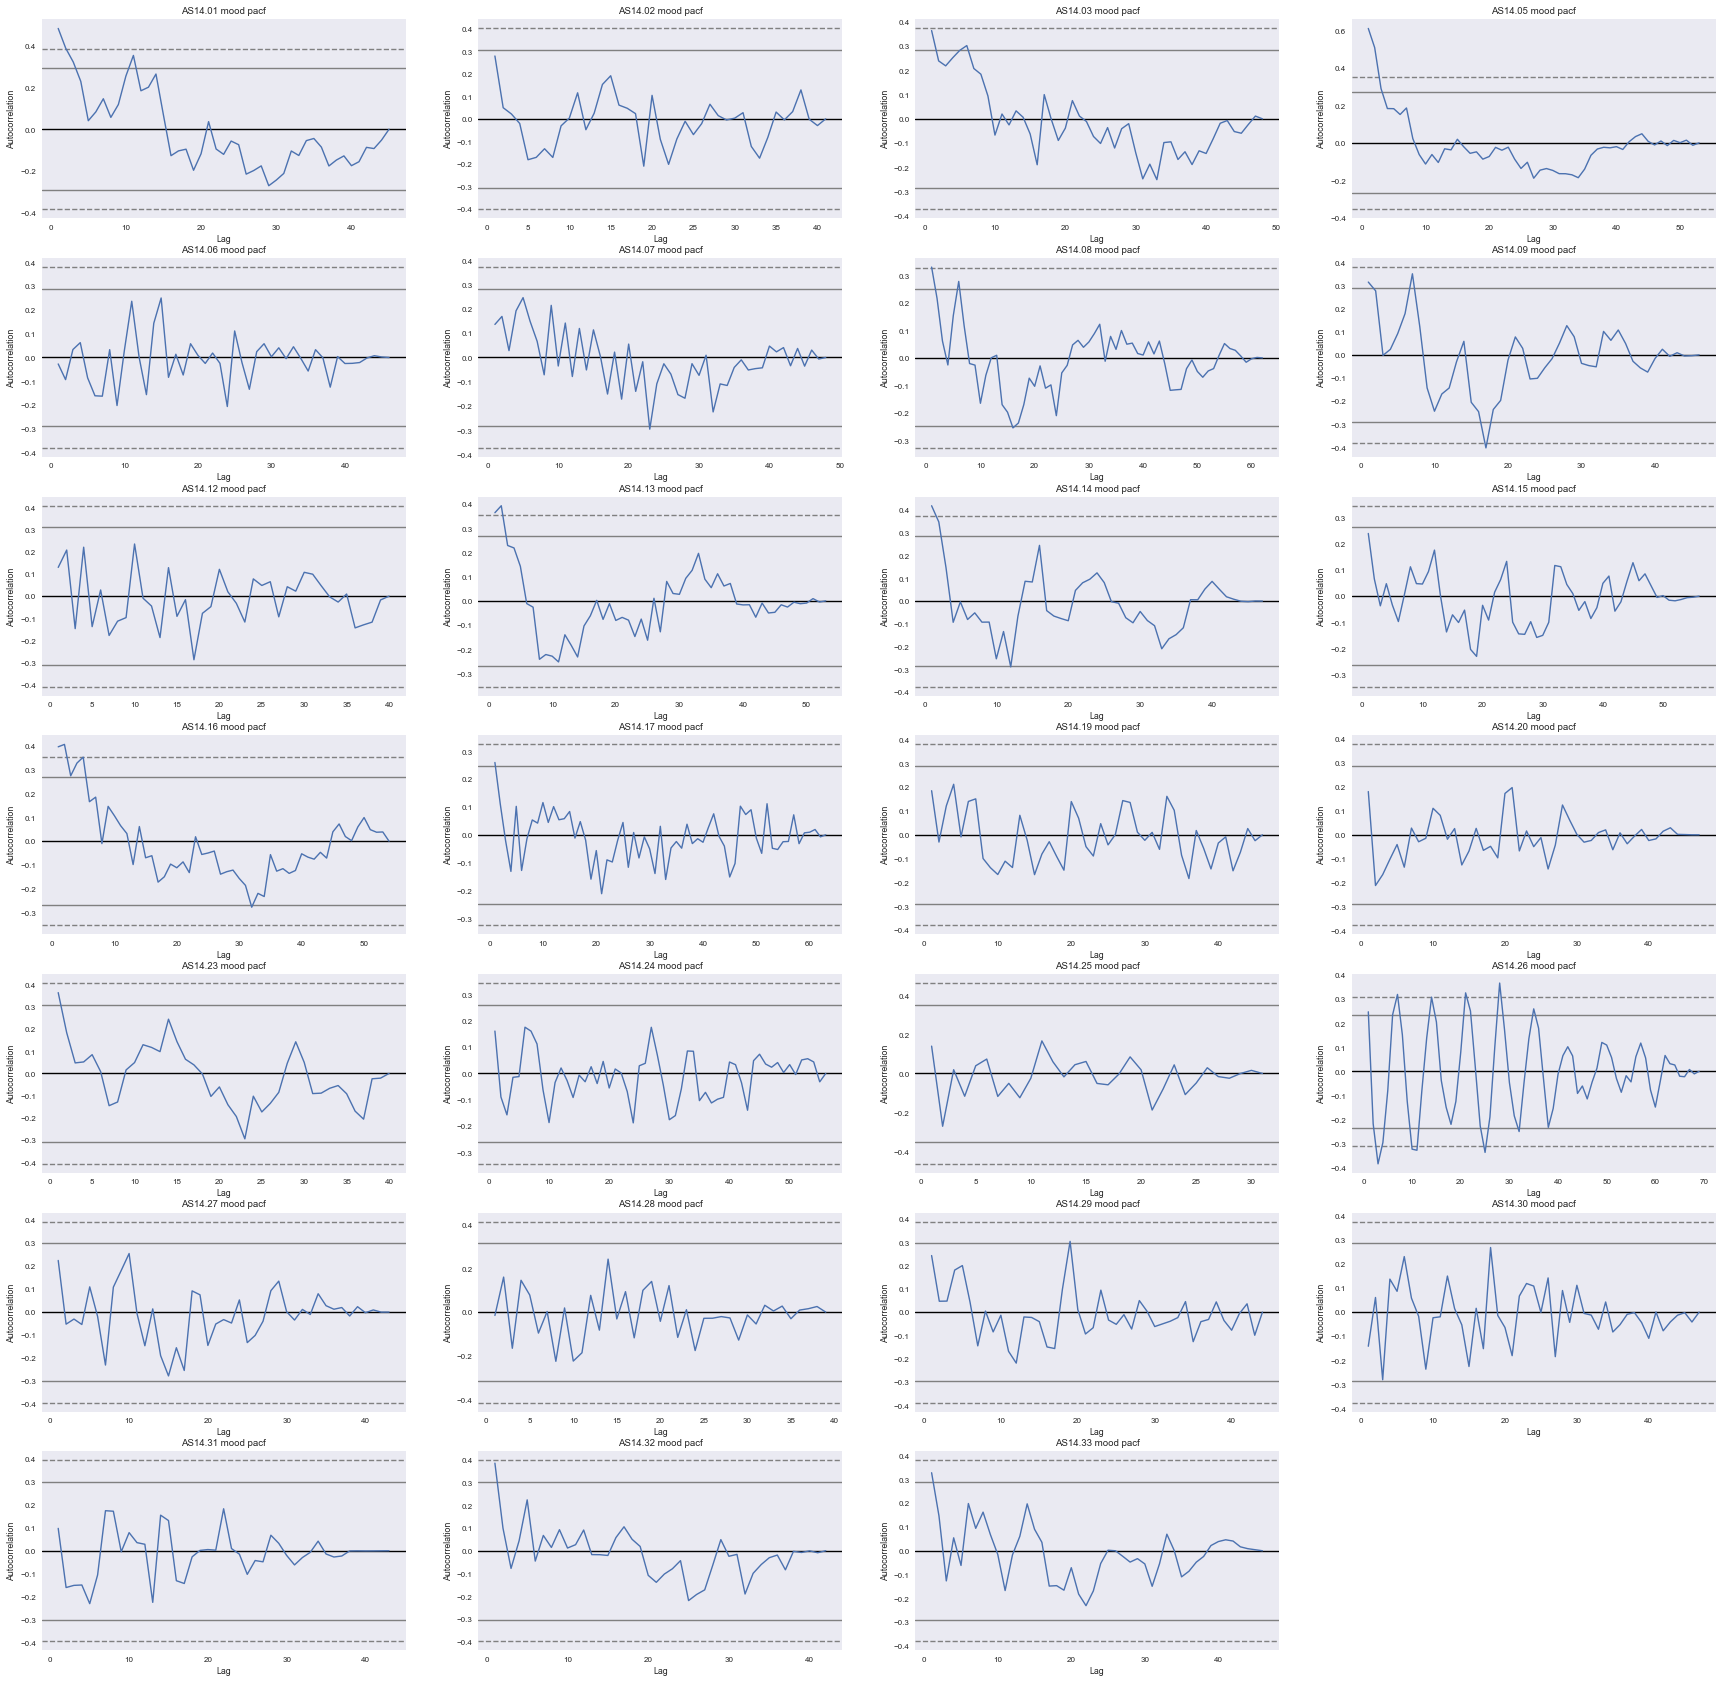

In [30]:
# 画出pacf函数
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(30,30))
for i,id in enumerate(ids):
    ax = fig.add_subplot(7,4,i+1)
    series = plotdf.loc[id, 'mood'].values
    pd.plotting.autocorrelation_plot(series,ax=ax)
    ax.set_title(id+' mood pacf')

# 从自相关性图中可以看到acf值表现出极强的相关性。

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 18)'>

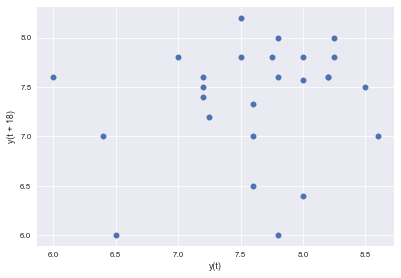

In [31]:
# 将上图AS14.31中相关性较强的lag=18单独画散点图，观察相关性
id='AS14.29'
lag=18
pd.plotting.lag_plot(plotdf.loc[id, 'mood'],lag=lag)

## 数据预处理和探索性数据分析结束
以newdf1d为最终处理结果进行模型建立

# 二、模型建立

### 1、BenchMark 模型
数据集使用按1天合并后的所有用户数据，所有属性不做删减、合并均作为特征

In [32]:
# benchmark model
import numpy as np
import pandas as pd
from sklearn import tree 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

In [33]:
def benchmarkdatadeal(dataset):
    predictcol='mood'
    featcols=list(dataset.columns)
    featcols.remove(predictcol)
    
    tmp=dataset.copy()
  
    # remove all attribute value is NaN rows
    tmp=tmp[tmp[featcols].notnull().any(axis=1)] 
    
    # 将call,sms转换为category
    tmp['call'] = tmp['call'].apply(lambda x:round(x) if x>0 else 0)#.astype('category')
    tmp['sms'] = tmp['sms'].apply(lambda x:round(x) if x>=0 else 0)#.astype('category')    
    # 替换所有NaN为0，模型要求不能有NaN
    tmp.loc[:,featcols]=tmp.loc[:,featcols].replace(to_replace=np.nan,value=0)
    return tmp

benchmarkdf=benchmarkdatadeal(newdf1d)
#benchmarkdf.to_csv('benchmarkdata.csv')
benchmarkdf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1295 entries, ('AS14.01', Timestamp('2014-03-21 00:00:00')) to ('AS14.33', Timestamp('2014-05-31 00:00:00'))
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1295 non-null   float64
 1   circumplex.arousal    1295 non-null   float64
 2   circumplex.valence    1295 non-null   float64
 3   activity              1295 non-null   float64
 4   call                  1295 non-null   int64  
 5   screen                1295 non-null   float64
 6   sms                   1295 non-null   int64  
 7   appCat.builtin        1295 non-null   float64
 8   appCat.communication  1295 non-null   float64
 9   appCat.entertainment  1295 non-null   float64
 10  appCat.finance        1295 non-null   float64
 11  appCat.game           1295 non-null   float64
 12  appCat.office         1295 non-null   float64
 13  appCat.other          1295 non-null   

In [34]:
# 划分训练集和测试集
predictcol='mood'
featcols=list(benchmarkdf.columns)
featcols.remove(predictcol)
train_x,test_x,train_y,test_y=train_test_split(benchmarkdf[featcols],benchmarkdf[predictcol],test_size=0.2,random_state=100)

In [35]:
benchmarkmodel = LinearRegression()
benchmarkmodel.fit(train_x, train_y)
pred_y=benchmarkmodel.predict(test_x)
print('(colname   wi):',[*zip(train_x.columns,benchmarkmodel.coef_)])
print('w0:',benchmarkmodel.intercept_)

(colname   wi): [('circumplex.arousal', 0.051674075484104305), ('circumplex.valence', 1.113820974651467), ('activity', 0.15154180664743977), ('call', 0.024881222321879812), ('screen', -6.82213133264199e-05), ('sms', 0.004372753639951739), ('appCat.builtin', 5.6938719188551034e-05), ('appCat.communication', 5.15356014364882e-05), ('appCat.entertainment', 0.0003380644439950358), ('appCat.finance', -0.0002033799361403981), ('appCat.game', 0.00012943369548372248), ('appCat.office', 0.0013461360414590774), ('appCat.other', 0.0005421909199584416), ('appCat.social', -1.528209894346079e-05), ('appCat.travel', 1.4389491674999131e-05), ('appCat.unknown', -0.00025444432906038527), ('appCat.utilities', 0.00031324015469199896), ('appCat.weather', 0.0046062959947952365)]
w0: 6.011458734920188


In [36]:
RMSE = mean_squared_error(test_y,pred_y)**0.5 
MAE = mean_absolute_error(test_y,pred_y)
R2 = r2_score(test_y,pred_y)
print('MAE=',MAE)
print('RMSE=',RMSE)
print('R2=',R2)

MAE= 0.3979228907561115
RMSE= 0.5163899197184628
R2= 0.5358176408256543


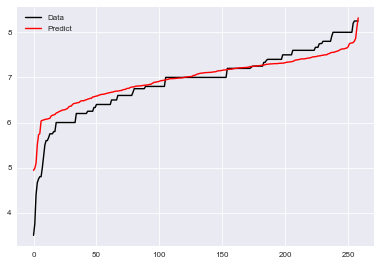

In [37]:
import matplotlib.pyplot as plt
plt.plot(range(len(test_y)),sorted(test_y),c="black",label= "Data")
plt.plot(range(len(pred_y)),sorted(pred_y),c="red",label = "Predict")
plt.legend()
plt.show()

### 2.特征工程模型
#### 1.滚动统计多日数据
通过按日期从大到小对数据集排序，滚动计算出每N天的属性，通过设置滚动窗口windows的值和属性列不同统计方法polymerizations的值，滚动统计函数见roll(df,id,window,polymerizations)，可计算出不同的特征属性数据集，程序提供多日滚动统计，根据抑郁患者多日行为对于mood影响力的不同，越靠近预测日的行为对预测日的mood值影响越大，因此设计了自定义的加权平均函数weightedmean，权值为1/sum(1..n)，2/sum(1..n),3/sum(1..n),...计算出最终的属性值

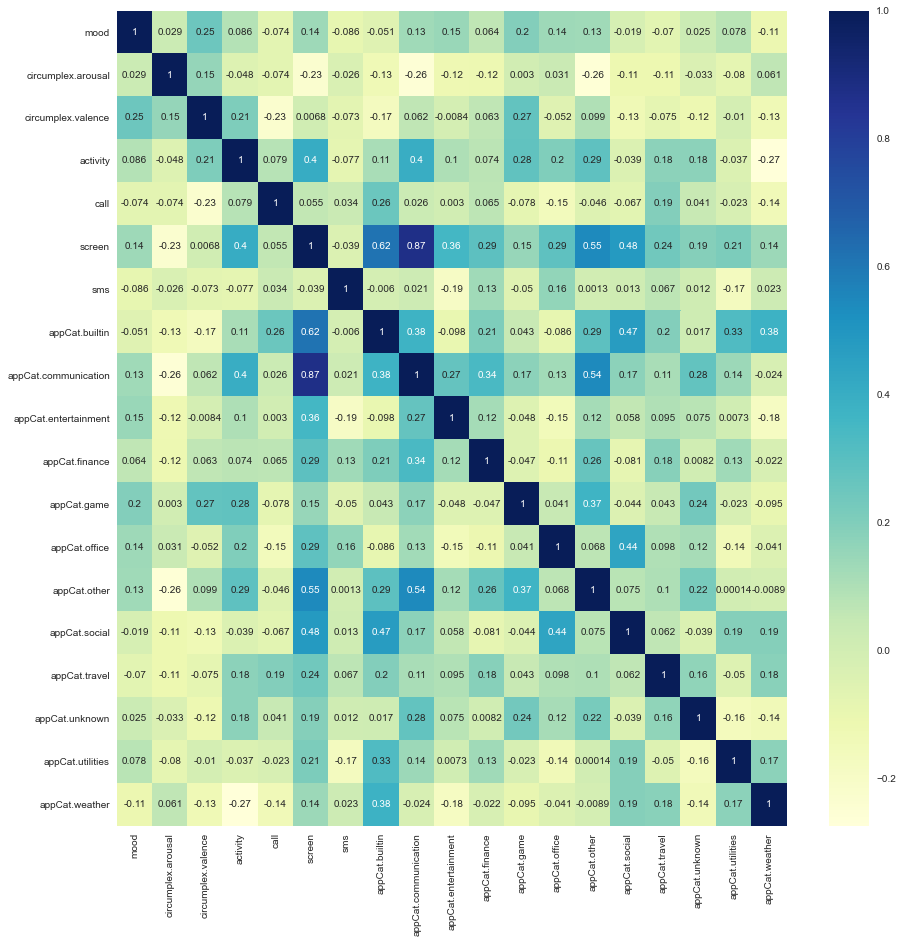

In [38]:
def weightedmean(x):
    '''
    自定义加权平均统计函数,根据预测值与越近的日期的variable影响越大，
    因此加权计算更合理，权值为1/sum(1..n)，2/sum(1..n),3/sum(1..n),...
    '''
    window=len(x)
    weights = np.arange(window,0,-1)
    weights=weights/np.sum(weights)
    # 去除NaN的影响，否则如果x有值NaN，计算结果为NaN
    x[np.isnan(x)] = 0
    weights[np.isnan(x)] = 0
    return np.average(x,axis=0,weights=weights)

def roll(df,id,window,polymerizations):
    '''
    按窗口滚动统计
    
    Args:
        df: dataframe
        id：dataset id
        window: polling window size
        polymerizations：cols 统计规则字典
        
    Returns:
        统计后的dataframe
    '''
    from pandas.api.indexers import FixedForwardWindowIndexer
    
    #从df中取出特定id集
    tmp=df[df['id']==id].copy()
    #设置time列为索引列
    tmp.set_index('time',inplace=True)  

    #取出mood列
    mood=tmp['mood']
    #将索引减去1天，设置前一天预测值
    mood.index=mood.index - datetime.timedelta(days=1)

    #滚动统计后window项各列，作为当前日期的值
    tmp=tmp.rolling(window=FixedForwardWindowIndexer(window_size=window),min_periods=1).agg(polymerizations,skipna=True)
    
    #设置id列
    tmp['id']=id
    #清空mood列，设置mood预测值
    tmp['mood']=np.nan
    tmp['mood']=mood
    
    return tmp

def datatransform(dataset,polymerizations,window=5):
    '''
    数据集滚动统计

    Args:
        df             ：需转换的dataframe
        polymerizations: 属性的统计方法字典
        window         :滚动统计计算的窗口，缺省为5天
        
    Returns:
        转换后的dataframe
    
    '''
    df=dataset.copy()
    df.reset_index(inplace=True)
    
    # 对数据集按'id','time'排序（降序）
    df.sort_values(by=['id','time'],inplace=True,ascending=False)
    
    # 取出所有id，并去重
    ids=df['id'].unique()
    frames = []  
    # 按id取出数据进行滚动统计
    for id in ids:
        frame=roll(df,id,window,polymerizations).reset_index()
        frames.append(frame)
    # 将不同id的数据集合并
    alldf=pd.concat(frames,ignore_index=True)
    alldf.set_index(['id','time'],inplace=True)
    return alldf

window=5

colspolymerization={'circumplex.valence':weightedmean,'activity':weightedmean,'call':weightedmean,'screen':weightedmean,
                    'appCat.builtin':weightedmean,'appCat.entertainment':weightedmean,'appCat.finance':weightedmean,
                    'appCat.office':weightedmean,'appCat.other':weightedmean,'appCat.social':weightedmean,'appCat.tools':weightedmean}
#经检验自定义函数数据统计正常，可以使用
polymerizationcols={'mood':'mean','circumplex.arousal':weightedmean,'circumplex.valence':weightedmean,'activity':weightedmean,'call':weightedmean,'screen':weightedmean,
                        'sms':weightedmean,'appCat.builtin':weightedmean,'appCat.communication':weightedmean,'appCat.entertainment':weightedmean,'appCat.finance':weightedmean,
                        'appCat.game':weightedmean,'appCat.office':weightedmean,'appCat.other':weightedmean,'appCat.social':weightedmean,'appCat.travel':weightedmean,
                        'appCat.unknown':weightedmean,'appCat.utilities':weightedmean,'appCat.weather':weightedmean}
polymerizationcols={'mood':'mean','circumplex.arousal':'mean','circumplex.valence':'mean','activity':'mean','call':'sum','screen':'sum',
                        'sms':'sum','appCat.builtin':'sum','appCat.communication':'sum','appCat.entertainment':'sum','appCat.finance':'sum',
                        'appCat.game':'sum','appCat.office':'sum','appCat.other':'sum','appCat.social':'sum','appCat.travel':'sum',
                        'appCat.unknown':'sum','appCat.utilities':'sum','appCat.weather':'sum'}

newdf=datatransform(newdf1d,polymerizationcols,window)
newdf.to_csv('rolldataset.csv')
# 绘制相关性
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(newdf.corr(), annot=True, cmap="YlGnBu");

#### 2、生成特征数据

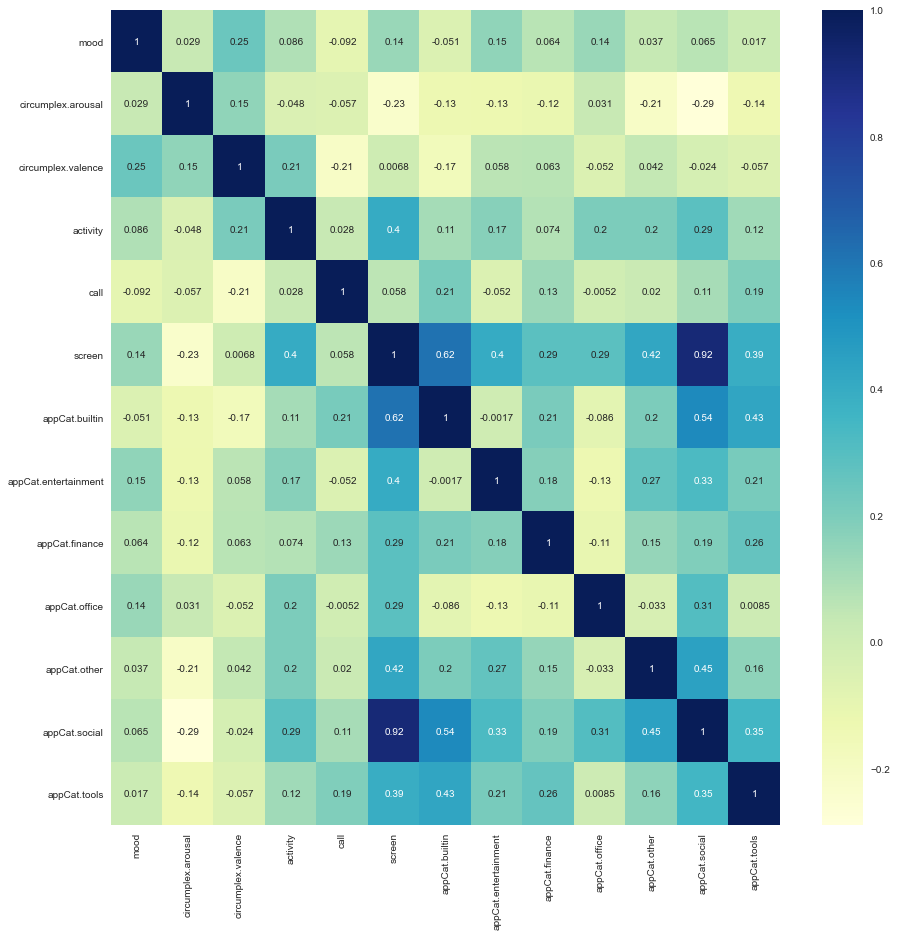

In [39]:
# 生成特征数据

def makefeatures(dataset,featuresdict):
    '''
    按照featuresdict特征字典的内容，求和合并多个属性为新的特征,或删除某个属性
    Args:
        dataset           ：源数据集
        featuresdict      ：特征字典
    Returns:
        合并后的dataframe

    '''    
    tmp=dataset.copy() 
    # 定义删除列列表
    delcols=[]
    # 取出特征字典中的key和value
    for item in featuresdict.items():
        key = item[0]
        value = item[1]
        # 对合并的属性列求和
        tmp[key] = tmp[value].sum(axis=1, skipna=True)
        # 判断合并项是否为空
        if value:
            # 判断新属性名还是原属性名
            if key in value:
                value.remove(key)
            # 将其加入删除列表
            delcols.extend(value)    
        else:
            # 合并项为空就删除key
            delcols.extend([key])        
    tmp = tmp.drop(columns=delcols, axis=1)
    
    return tmp

# featuresdict例子
# featuresdict={'appCat.entertainment':['appCat.game','appCat.entertainment'],#合并属性保存再原属性名中
#              'appCat.tools':['appCat.travel','appCat.utilities','appCat.weather'],#合并属性保存新的appCat.tools属性中
#              'sms':[]}#删除属性

# 特征生成
# appCat.game,appCat.entertainment 都应属于entertainment类，appCat.communication,appCat.social 都应属于social类
# appCat.travel,appCat.utilities,appCat.weather 都属于tool类，appCat.other,appCat.unknow 属于other类
# call,sms 属于call类,但数据计数类不能与social的时间类合并
featuresdict={'appCat.entertainment':['appCat.game','appCat.entertainment'],
              'appCat.social':['appCat.communication','appCat.social'],
              'appCat.tools':['appCat.travel','appCat.utilities','appCat.weather'],
              'appCat.other':['appCat.other','appCat.unknown'],
              'call':['call','sms']}
featuresdf=makefeatures(newdf,featuresdict)
# 绘制相关性
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(featuresdf.corr(), annot=True, cmap="YlGnBu");

#### 3. 进一步数据预处理

In [40]:
def featuresdatadeal(dataset):
    '''
    对数据进行处理，删除无效列、NaN值、无意义行,填充空值等
    Args:
        newdf             ：需转换的dataframe
        
    Returns:
        处理后的dataframe

    '''

    tmp=dataset.copy()
    predictcol='mood'
    featcols=list(tmp.columns)
    featcols.remove(predictcol) 
    
    # 删除mood列为NaN的行
    tmp.dropna(axis=0,subset =[predictcol],inplace=True)
    
    # remove all attribute value is NaN rows
    tmp=tmp[tmp[featcols].notnull().any(axis=1)] 
    
    # 将call,sms转换为category
    tmp['call'] = tmp['call'].apply(lambda x:round(x) if x>0 else 0)#.astype('category')  
    # 替换所有NaN为0，多元线性回归特征不能有NaN
    tmp.loc[:,featcols]=tmp.loc[:,featcols].replace(to_replace=np.nan,value=0)
    
    return tmp

featuresdf=featuresdatadeal(featuresdf)
#featuresdf.to_csv('featuresdata.csv')
featuresdf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1295 entries, ('AS14.33', Timestamp('2014-04-15 00:00:00')) to ('AS14.01', Timestamp('2014-05-03 00:00:00'))
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mood                  1295 non-null   float64
 1   circumplex.arousal    1295 non-null   float64
 2   circumplex.valence    1295 non-null   float64
 3   activity              1295 non-null   float64
 4   call                  1295 non-null   int64  
 5   screen                1295 non-null   float64
 6   appCat.builtin        1295 non-null   float64
 7   appCat.entertainment  1295 non-null   float64
 8   appCat.finance        1295 non-null   float64
 9   appCat.office         1295 non-null   float64
 10  appCat.other          1295 non-null   float64
 11  appCat.social         1295 non-null   float64
 12  appCat.tools          1295 non-null   float64
dtypes: float64(12), int64(1)
memory usage:

In [41]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import os

#### 4.划分训练集和测试集

In [42]:
predictcol='mood'
featcols=list(featuresdf.columns)
featcols.remove(predictcol) 

train_x,test_x,train_y,test_y=train_test_split(featuresdf[featcols],featuresdf[predictcol],test_size=0.2,random_state=100)

#### 5. 建立模型  

#### 1) 多元线性回归

In [43]:
benchmarkmodel = LinearRegression()
benchmarkmodel.fit(train_x, train_y)
pred_y=benchmarkmodel.predict(test_x)
print('(colname   wi):',[*zip(train_x.columns,benchmarkmodel.coef_)])
print('w0:',benchmarkmodel.intercept_)

(colname   wi): [('circumplex.arousal', 0.013695598582255792), ('circumplex.valence', 0.397575779382418), ('activity', -0.7216315859670202), ('call', -0.0018368095549450068), ('screen', 2.9329545303876425e-05), ('appCat.builtin', -3.827430420747189e-05), ('appCat.entertainment', 3.584397146819858e-05), ('appCat.finance', -9.988635586082129e-05), ('appCat.office', 0.00015511099862276895), ('appCat.other', -2.6357173110205995e-05), ('appCat.social', -2.0812092054845558e-05), ('appCat.tools', -1.4851565560852225e-05)]
w0: 6.726423007334987


#### 模型评价

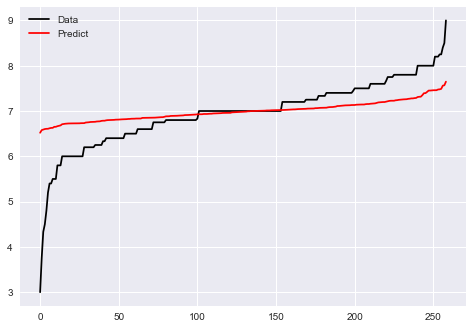

In [44]:
plt.plot(range(len(test_y)),sorted(test_y),c="black",label= "Data")
plt.plot(range(len(pred_y)),sorted(pred_y),c="red",label = "Predict")
plt.legend()
plt.show()

In [45]:
RMSE = mean_squared_error(test_y,pred_y)**0.5 
MAE = mean_absolute_error(test_y,pred_y)
R2 = r2_score(test_y,pred_y)
print('RMSE=',RMSE)
print('MAE=',MAE)
print('R2=',R2)

RMSE= 0.6948124359268378
MAE= 0.5038823419757172
R2= 0.13626499463805208


#### 2）随机森林回归

In [46]:
rfc = RandomForestRegressor(random_state=0)
rfc = rfc.fit(train_x,train_y)#用训练集数据训练模型
pred_y=rfc.predict(test_x)
result = rfc.score(test_x,test_y)
print(result)
print(*zip(featcols,rfc.feature_importances_))

0.2605631601473126
('circumplex.arousal', 0.08551423612954137) ('circumplex.valence', 0.11105995051100494) ('activity', 0.09044710538250493) ('call', 0.0705370548433628) ('screen', 0.07496588603695652) ('appCat.builtin', 0.07981222687612258) ('appCat.entertainment', 0.0951769781790145) ('appCat.finance', 0.03373122185046663) ('appCat.office', 0.08665205179536348) ('appCat.other', 0.11388699778200535) ('appCat.social', 0.07095150502842341) ('appCat.tools', 0.08726478558523355)


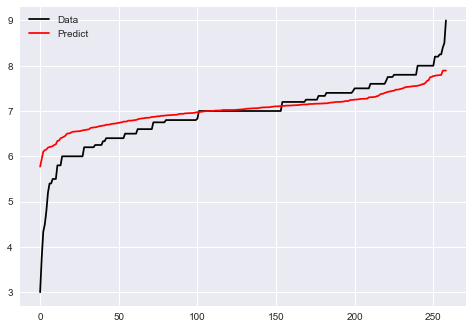

In [58]:
plt.plot(range(len(test_y)),sorted(test_y),c="black",label= "Data")
plt.plot(range(len(pred_y)),sorted(pred_y),c="red",label = "Predict")
plt.legend()
plt.show()

In [59]:
RMSE = mean_squared_error(test_y,pred_y)**0.5 
MAE = mean_absolute_error(test_y,pred_y)
R2 = r2_score(test_y,pred_y)
print('RMSE=',RMSE)
print('MAE=',MAE)
print('R2=',R2)

RMSE= 0.6257596057634833
MAE= 0.4341076151117528
R2= 0.29941569279191904


#### 3)决策树回归

In [60]:
clf = tree.DecisionTreeRegressor(random_state=0)
clf = clf.fit(train_x,train_y)#用训练集数据训练模型
pred_y=clf.predict(test_x)
result = clf.score(test_x,test_y)
print(result)
print(*zip(featcols,clf.feature_importances_))

-0.3932166025996662
('circumplex.arousal', 0.0720127408364731) ('circumplex.valence', 0.07773729301050951) ('activity', 0.11854650858333539) ('call', 0.07135753975279514) ('screen', 0.06333389574717206) ('appCat.builtin', 0.06306617791136525) ('appCat.entertainment', 0.09088279544738265) ('appCat.finance', 0.05020768987695936) ('appCat.office', 0.12179105879842626) ('appCat.other', 0.125553624589392) ('appCat.social', 0.044341790104938) ('appCat.tools', 0.10116888534125137)


#### 模型评价

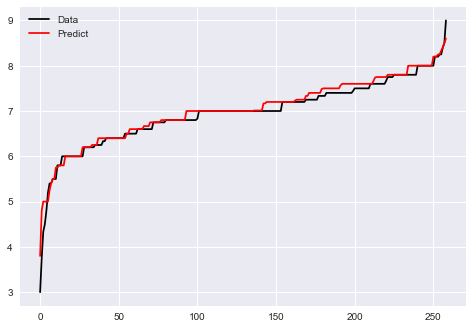

In [61]:
plt.plot(range(len(test_y)),sorted(test_y),c="black",label= "Data")
plt.plot(range(len(pred_y)),sorted(pred_y),c="red",label = "Predict")
plt.legend()
plt.show()

In [62]:
RMSE = mean_squared_error(test_y,pred_y)**0.5 
MAE = mean_absolute_error(test_y,pred_y)
R2 = r2_score(test_y,pred_y)
print('RMSE=',RMSE)
print('MAE=',MAE)
print('R2=',R2)

RMSE= 0.882442960679085
MAE= 0.6356422749279892
R2= -0.3932166025996662


### 3、时间序列模型——ARIMA model
ARIMA模型是时序单变量模型

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
%matplotlib inline


In [81]:
# step1 划分训练集合测试集

id='AS14.05'
newdf1d=newdf1d.sort_index()
plotdf=newdf1d.copy()
y = plotdf.loc[id, 'mood']
n=round(0.2*y.shape[0])
train_data = y[:y.shape[0]-n]
test_data = y[y.shape[0]-n-1:]  #以最后n点作为待预测值


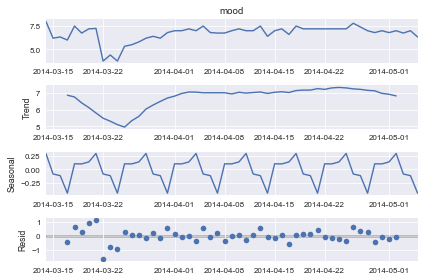

In [82]:
# 数据集不存在明显趋势项（图二），但存在季节项（图三周期性变化）
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(y, model='additive')
x = decomposed.plot()

In [85]:
# step2，检查平稳性
#原假设是不平稳的，1%、%5、%10不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设，
# adf大于三个level的统计值。所以是不平稳的，需要进行一阶差分后，再进行检验。
# p-value是否<0.05,非常接近0，接近0，则是平稳的，否则，不平稳。
result = adfuller(y, autolag='AIC')
print(result)
print('ADF Statistic',result[0],'p-value:',result[1],'Stationary:',result[1]<0.05)

(-2.630220851645002, 0.08691069199632495, 2, 50, {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}, 21.207385984403615)
ADF Statistic -2.630220851645002 p-value: 0.08691069199632495 Stationary: False


In [84]:
# setp3,对于平稳可不运行该step，对不平稳，进行差分处理，再次进行step2,确定d值
train_data = train_data.diff().dropna()
test_data = test_data.diff().dropna()

In [86]:
# step4 白噪声检验
# 原假设为白噪声，lb_pvalue<0.05时拒绝原假设，非白噪声
from statsmodels.stats.diagnostic import acorr_ljungbox as ljbox
ljbox(train_data, lags=1,return_df=True)

,lb_stat,lb_pvalue
1,4.019627,0.044974


Text(0.5, 1.0, 'AS14.05 mood pacf')

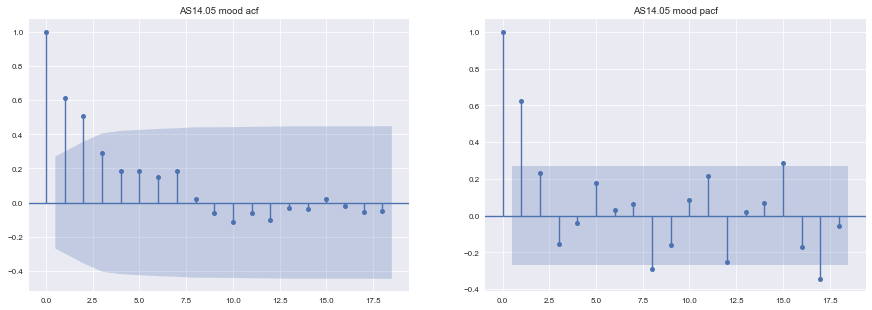

In [87]:
# step5 画出acf函数,确定p，q
# 蓝色底色区域内画出的是95%置信区间，数据落在蓝色区域内表示在统计学意义上在x轴的时间间隔下具有自相关性
plt.style.use('seaborn-paper')
palette = plt.get_cmap('tab20')

fig= plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
series = y.values
plot_acf(series,ax=ax)
ax.set_title(id+' mood acf')
ax = fig.add_subplot(1,2,2)
series = y.values
plot_pacf(series,ax=ax)
ax.set_title(id+' mood pacf')

In [88]:
# step6 拟合模型
model=ARIMA(train_data, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   mood   No. Observations:                   41
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -55.136
Date:                Tue, 19 Apr 2022   AIC                            114.272
Time:                        22:23:07   BIC                            117.650
Sample:                    03-15-2014   HQIC                           115.493
                         - 04-24-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6765      0.092     -7.382      0.000      -0.856      -0.497
sigma2         0.9081      0.113      8.065      0.000       0.687       1.129
Ljung-Box (L1) (Q):                   1.31   Jarque-

C:\Users\frank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\frank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\frank\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [89]:
# 拟合模型，自动选择参数
arima_model = auto_arima(train_data, start_p=0, d=1,start_q=0, max_p=8,max_d=8,max_q=8,
                         start_P=0, D=1, start_Q=0, max_P=8, max_D=8, max_Q=8, m=12, seasonal=True,trace=True,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=115.332, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=99.352, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=97.757, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=99.321, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=96.869, Time=0.02 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=98.180, Time=0.05 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=98.120, Time=0.08 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=100.078, Time=0.26 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=98.825, Time=0.05 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=98.178, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=92.760, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=93.912, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=93.822, 

In [90]:
# 查看模型
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   41
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                 -43.380
Date:                             Tue, 19 Apr 2022   AIC                             92.760
Time:                                     22:23:17   BIC                             96.757
Sample:                                          0   HQIC                            93.982
                                              - 41                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3639      0.256     -1.423      0.155      -0.865       0.137
ma.L1         -0.9285      0.259     -3.588      0.000      -1.436      -0.421
sigma2         1.1789      0.344      3.425      0.001       0.504       1.854
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.49
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.83
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

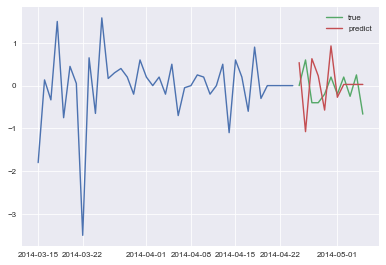

In [91]:
# step5，预测时间序列，并和真实值比较
pred = pd.DataFrame(arima_model.predict(n_periods=n),columns=['predicted'],index=test_data.index)
plt.plot(train_data)
plt.plot(test_data,label='true')
plt.plot(pred,label='predict')
plt.legend();

### 模型评价

In [94]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score


RMSE = mean_squared_error(test_data,pred)**0.5 
MAE = mean_absolute_error(test_data,pred)
R2 = r2_score(test_data,pred)
print('RMSE=',RMSE)
print('MAE=',MAE)
print('R2=',R2)

RMSE= 0.7299760337927446
MAE= 0.5825952225996079
R2= -3.3704763381203913
